# <p style="text-align:center;">**HOTEL BOOKING DEMAND**</p>


# **Business Understanding**

## Context : 
Industri perhotelan menjadi salah satu sektor yang bertumbuh cukup pesat di Portugal. Pada tahun 2019 pendapatan tahunan sektor ini meningkat [7,4% y-o-y](https://www.statista.com/statistics/1058491/sales-revenue-tourism-sector-portugal/). Diantara tren positif ini masih terdapat satu masalah yang dialami oleh Hotel di Portugal yaitu tamu/pelanggan yang membatalkan pesanan (cancel) terutama pada detik-detik terakhir. 

Hotel di Portugal ingin ada sebuah machine learning yang cukup akurat untuk memberi prediksi bahwa apakah tamu atau pelanggan ini akan membatalkan pesananannya atau tidak. Oleh karena itu mereka menugaskan data scientist untuk mendapatkan insight terkait pelanggan yang cancel dan juga membuat machine learning untuk menyelesaikan masalah tersebut.

Target :

0 : No Cancel

1 : Canceled


## Problem Statement :
*Last minute cancelation* atau *late cancelation* sangat mengganggu dalam proyeksi revenue dari hotel tesebut. Hal ini disebabkan karena jika seorang pelanggan *no show (include Last minute cancelation atau late cancelation)*, pihak hotel mungkin akan menghadapi resiko kamar kosong yang tidak dapat dijual lagi. Dalam kasus ini hotel juga sudah melakukan pengeluaran untuk operasional terkait tamu tersebut, seperti membersihkan dan menyiapkan kamar, yang akhirnya terbuang percuma. Cancelation ini juga salah satu alasan mengapa overbooking terjadi, tetapi dalam kasus kali ini, kita berbicara tentang *Last minute cancelation* atau *late cancelation*.

Pada akhirnya kita bisa simpulkan bahwa *Last minute cancelation* atau *late cancelation* di hotel berarti kehilangan pendapatan dan bahkan mengalami kerugian. 

## Goals :

Maka berdasarkan permasalahan tersebut, hotel ingin memiliki kemampuan untuk memprediksi kemungkinan seorang tamu melakukan cancel atau tidak, sehingga dapat melakukan upaya untuk mengantisi dan mempertahankan tamu yang terindikasi akan melakukan cancel.

Dan juga, perusahaan ingin mengetahui tamu dengan kategori seperti apa dan faktor-faktor apa saja yang cenderung membuat tamu tidak membatalkan pesanannya, sehingga hotel dapat membuat program-program yang lebih tepat sasaran dalam mengurangi jumlah pelanggan yang cancel.


## Analytic Approach :

Dalam kasus kali ini kita akan mencoba menemukan kategori pengunjung seperti apa yang cenderung membatalkan pesanannya (cancel).

Kemudian kita akan membangun model klasifikasi yang akan membantu perusahaan untuk dapat memprediksi probabilitas seorang pelanggan akan berhenti cancel atau tidak.


## Metric Evaluation :
Fokus dalam permodelan ini adalah tamu yang membatalkan pesanannya (cancel), maka target yang digunakan adalah `is_canceled` dengan detail sebagai berikut:

Target :
- 0 : Melanjutkan pesanan (No Cancel)
- 1 : Membatalkan pesanan (Cancel)

Type 1 error : False Positive (pelanggan yang aktualnya No Cancel tetapi diprediksi Cancel)
Konsekuensi: Kemungkinan terjadinya Overbooking karena hotel sudah menjual kamar tersebut ke tamu lain.

Type 2 error : False Negative (pelanggan yang aktualnya Cancel tetapi diprediksi No Cancel)
Konsekuensi: Hotel kehilangan pendapatan

Untuk memberikan dampak yang dapat dirasakan oleh hotel secara kuantitatif, maka kita akan coba hitung dampak biaya berdasarkan asumsi berikut :

Salah satu parameter mengukur pendapatan hotel dapat diketahui dari Occupancy hotel tersebut. Perhitungan Occupancy terhitung dari awal tamu/pelanggan melakukan pesanan (pada beberapa hotel tidak perlu melakukan pembayaran awal untuk memastikan kamar kita). Dalam perhotelan terdapat istiah CPOR (Cost Per Occupied Room), dimana terdapat komponen biaya yang harus dikeluarkan dari setiap kamar yang terisi, dan *late cancelation* juga masih terhitung sebagai kamar terisi karena kamar tersebut tetap memerlukan pembersihan, alokasi sarapan dan fasilitas-fasilitas lain yang ada pada hotel tersebut.
 
Pada sebuah hotel yang memiliki 100 kamar dengan harga US$100/night memiliki tingkat occupancy sebesar 80%. Memiliki COPR sebesar [15%](https://tgandh.com/articles/hospitality/rate-vs-cpor-against-guest-satisfaction/) dan tingkat cancelation sebesar [10%](https://www.appointmentreminders.com/how-is-a-no-show-rate-calculated/).

- Proyeksi awal pendapatan hotel per malam = 100 kamar x 80% x US$100 = US$8,000
- COPR = 15% x US$8,000 = US$1,200
- Pendapatan yang hilang karena Cancelation = 10% x (80% x 100 kamar) x US$100 = US$800
- COPR yang terbuang = 10% x US$1,200 = US$120

Dari gambaran tersebut kita bisa lihat bahwa potensi kerugian hotel :
- Pendapatan Kamar yang hilang = US$800
- Pengeluaran yang terbuang sia-sia= US$120

Jadi kerugian yang diakibatkan oleh cancelation bukan 1 : 1 dengan harga kamar, tetapi dari setiap cancelation mengakibatkan kerugian **1,15 kali lipat** dibanding harga kamar, atau jika dalam nominal maka menjadi :
- harga rata-rata kamar hotel di Portugal : [$99](https://www.budgetyourtrip.com/hotels/portugal-PT)
- total kerugian tiap 1 tamu melakukan cancel = 1.15 x $99 = **$113.85** 

Berdasarkan dampaknya maka kita ingin agar model dapat mengurangi jumlah False Negative (pelanggan yang aktualnya cancel tetapi diprediksi No Cancel). Maka metric utama yang akan digunakan adalah **Recall** atau juga diketahui sebagai True Positive Rate (TPR).


## Library :

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from typing import Literal
from IPython.display import Markdown

from scipy.stats import normaltest
from scipy.stats.mstats import winsorize
from statsmodels.stats.outliers_influence import variance_inflation_factor 


from category_encoders import BinaryEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, classification_report, f1_score, fbeta_score, make_scorer, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay

from imblearn.over_sampling import RandomOverSampler, SMOTENC, SMOTE
from imblearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier



# **Data Understanding**

## *Attribute Information*

In [2]:
hotel_data =pd.read_csv('data_hotel_booking_demand.csv')
display(hotel_data.shape)
display(hotel_data.head())
print ('Data Information')
display(hotel_data.info())
print ('Missing Value')
display(hotel_data.isna().sum())
display(f"Jumlah duplikasi data: {hotel_data[hotel_data.duplicated()].shape}")
display(f'Persentase sebesar {(hotel_data.duplicated().sum())/len(hotel_data)*100}%')

(83573, 11)

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


Data Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


None

Missing Value


country                        351
market_segment                   0
previous_cancellations           0
booking_changes                  0
deposit_type                     0
days_in_waiting_list             0
customer_type                    0
reserved_room_type               0
required_car_parking_spaces      0
total_of_special_requests        0
is_canceled                      0
dtype: int64

'Jumlah duplikasi data: (73371, 11)'

'Persentase sebesar 87.79270817129934%'

***Insight*** :
- Dataset ini memiliki jumlah baris awal sebanyak 83,573 baris dan 11 kolom
- Terdapat 5 kolom dengan kategori object dan 6 kategori dengan format integer
- Terdapat 351 missing value pada kolom `country`
- Dataset memiliki duplikasi data sebanyak 73,371 data atau 87,8% dari total data 

**Attribute Information**

| Attribute | Data Type | Description |
| --- | --- | --- | 
|country |object | Country of origin of the guest |
|market_segement |object | Market segment designation |
|previous_cancellations |Integer | Number of previous bookings that were canceled by the customer |
|booking_changes |Integer |Number of changes made to the booking |
|deposit_type |object | Type of deposit made (No Deposit, Refundable, Non Refund) |
|days_in_waiting_list |Integer | Number of days the booking was in the waiting list |
|customer_type |object | Type of customer (Transient, Contract, Transient-Party, Group) |
|reserved_room_type |object | Type of reserved room |
|required_car_parking_space |Integer | Number of car parking spaces required |
|total_of_special_request |Integer | Number of special requests made |
|is_canceled |Integer | Reservation cancellation status (0 = not canceled, 1 = canceled) |

Disini kita akan mencari tahu nilai unik dari masing-masing kolom yang ada:

In [3]:
pd.set_option('display.max_colwidth',None)

# Data unik disetiap kolom
list_unik = []
for col in hotel_data.columns :
    list_unik.append([col, hotel_data[col].nunique(), hotel_data.sort_values(col)[col].unique()])

Datadesc = pd.DataFrame(columns=['Nama Kolom','Jumlah Unik', 'Unik Value'],
                        data=list_unik)
Datadesc

,Nama Kolom,Jumlah Unik,Unik Value
0,country,162,"[ABW, AGO, AIA, ALB, AND, ARE, ARG, ARM, ATA, AUS, AUT, AZE, BDI, BEL, BEN, BFA, BGD, BGR, BHR, BIH, BLR, BOL, BRA, BRB, BWA, CAF, CHE, CHL, CHN, CIV, CMR, CN, COL, COM, CPV, CRI, CUB, CYM, CYP, CZE, DEU, DMA, DNK, DOM, DZA, ECU, EGY, ESP, EST, ETH, FIN, FRA, FRO, GAB, GBR, GEO, GGY, GHA, GIB, GLP, GNB, GRC, GTM, HKG, HRV, HUN, IDN, IMN, IND, IRL, IRN, IRQ, ISL, ISR, ITA, JAM, JEY, JOR, JPN, KAZ, KEN, KHM, KIR, KNA, KOR, KWT, LAO, LBN, LBY, LCA, LIE, LKA, LTU, LUX, LVA, MAC, MAR, MDV, MEX, MKD, ...]"
1,market_segment,8,"[Aviation, Complementary, Corporate, Direct, Groups, Offline TA/TO, Online TA, Undefined]"
2,previous_cancellations,15,"[0, 1, 2, 3, 4, 5, 6, 11, 13, 14, 19, 21, 24, 25, 26]"
3,booking_changes,19,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 20, 21]"
4,deposit_type,3,"[No Deposit, Non Refund, Refundable]"
5,days_in_waiting_list,115,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 68, 69, 70, 71, 73, 74, 75, 76, 77, 79, 80, 83, 84, 85, 87, 91, 92, 93, 96, 97, 98, 99, 100, 101, 105, 107, 108, 111, 113, 120, 121, 122, 125, 147, 150, 160, 162, 165, 174, ...]"
6,customer_type,4,"[Contract, Group, Transient, Transient-Party]"
7,reserved_room_type,10,"[A, B, C, D, E, F, G, H, L, P]"
8,required_car_parking_spaces,5,"[0, 1, 2, 3, 8]"
9,total_of_special_requests,6,"[0, 1, 2, 3, 4, 5]"


***insight*** :
| Market Segment | Description |
| --- |  --- | 
|TA | Travel Agent |
|TO | Travel Operator |

---
| Deposit Type | Description |
| --- |  --- | 
|No Deposit | variable indicating whether a deposit was made |
|Non Refund | variable indicating whether a deposit was made in the value of the total stay cost |
|Refundable | variable indicating whether a deposit was made with a value under the total stay cost |
---
| Customer Type | Description |
| --- |  --- | 
|Contract | the booking has an allotment or other type of contract associated to it |
|Group | the booking is associated to a group |
|Transient |  the booking is not part of a group or contract, and is not associated to other transient booking |
|Transient - Party | the booking is transient, but is associated to at least another transient booking |



Karena hanya terdapat 1 nilai Undefined pada kolom market_segment yang kita anggap sebagai missing value, maka nilai tersebut akan didrop dari dataframe ini.

In [4]:
hotel_data = hotel_data[hotel_data['market_segment'] != 'Undefined']

# **Exploratory Data Analysis**

Sebelum melakukan Exploratory Data Analysis kita akan menghilangkan data duplikat terlebih dulu agar bisa mendapatkan insight yang lebih jernih

In [5]:
hotel_data.drop_duplicates(inplace=True)

Disini kita akan membagi kolom menjadi 2 tipe yaitu kolom dengan format sebagai object akan dimasukan sebagai `categorical` dan kolom dengan format integer akan dikategorikan sebagai `numerical`

In [6]:
categorical =  [feature for feature in hotel_data.columns if hotel_data[feature].dtypes == 'object']

numerical = [feature for feature in hotel_data.describe().columns]


## Data Distribution

In [7]:
dist = []

for i in range(len(numerical)):
    feature_name = numerical[i]
    stat, p_value = normaltest(hotel_data[feature_name].dropna())
    
    if p_value > 0.05:
        distribution = "Normally Distributed"
    else:
        distribution = "Not Normally Distributed"
    
    dist.append([feature_name, stat, p_value, distribution])

dist_df = pd.DataFrame(dist, columns=['Feature', "D'Agostino-Pearson Statistic", 'P-value', 'Distributed'])
dist_df

,Feature,D'Agostino-Pearson Statistic,P-value,Distributed
0,previous_cancellations,21751.094612,0.000000e+00,Not Normally Distributed
1,booking_changes,8547.662804,0.000000e+00,Not Normally Distributed
2,days_in_waiting_list,14875.682311,0.000000e+00,Not Normally Distributed
3,required_car_parking_spaces,7944.311202,0.000000e+00,Not Normally Distributed
4,total_of_special_requests,1230.788672,5.465573e-268,Not Normally Distributed
5,is_canceled,1806.955395,0.000000e+00,Not Normally Distributed


***Insight***:

Berdasarkan normality test dengan metode D'Agostino-Pearson maka kita dapati bahwa semua kolom tidak terdistribusi normal


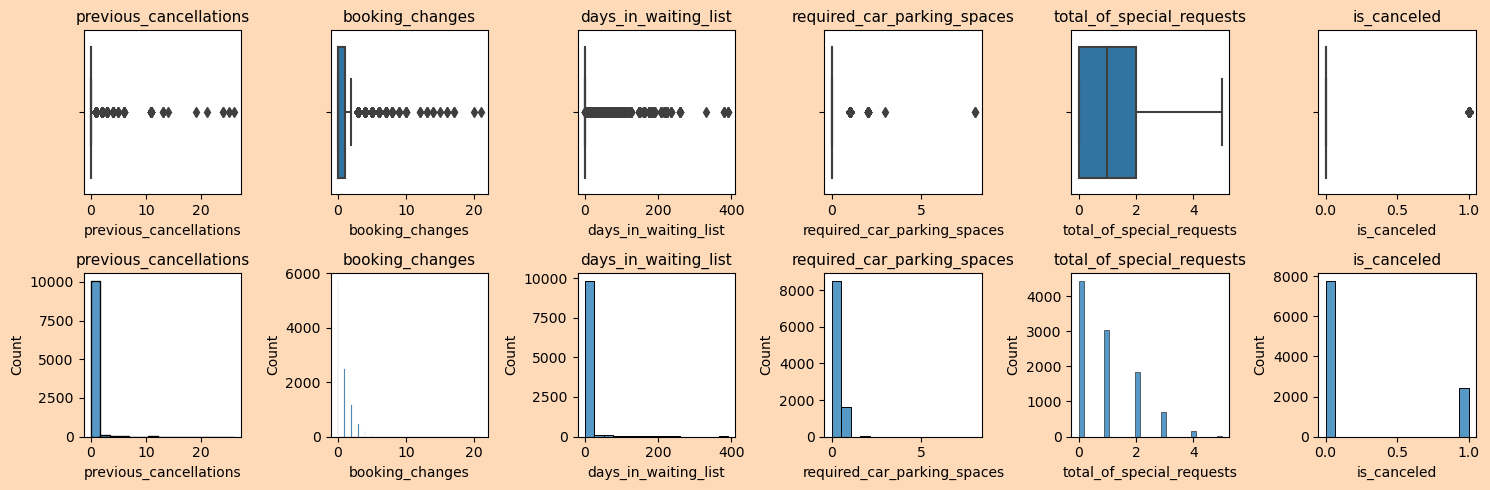

In [8]:
plt.figure(figsize=(15, 5), facecolor='peachpuff')
plotnumber = 1
    
for feature in numerical:
    ax = plt.subplot(2,6, plotnumber)
    sns.boxplot(x=feature, data=hotel_data)
    plt.title(feature, fontsize=11)
    plt.tight_layout()
    plotnumber += 1

for feature in numerical:
    ax = plt.subplot(2,6, plotnumber)
    sns.histplot(x=feature, data=hotel_data)
    plt.title(feature, fontsize=11)
    plt.tight_layout()
    plotnumber += 1
plt.show()

***Insight*** :

Dari box plot dan grafik batang diatas dapat terlihat jelas bahwa kolom numerical tidak terdistribusi normal dan memiliki nilai outlier.

## Descriptive Statistic

In [9]:
display(hotel_data.describe(), hotel_data.describe(include='object'))

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,10201.000000,10201.000000,10201.000000,10201.000000,10201.000000,10201.000000
mean,0.089305,0.795118,3.560631,0.167140,0.941182,0.236545
std,0.828514,1.293263,22.197696,0.393828,1.038037,0.424982
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000,1.000000


,country,market_segment,deposit_type,customer_type,reserved_room_type
count,10083,10201,10201,10201,10201
unique,162,7,3,4,10
top,PRT,Online TA,No Deposit,Transient,A
freq,1992,4945,9959,6911,4627


***insight*** :
**Numerical Feature**
- `previous_cancellations`: Rata-rata, tamu telah membatalkan sekitar 0,09 kali di masa lalu, dengan beberapa tamu memiliki hingga 26 pembatalan sebelumnya.
- `booking_changes`: Pemesanan diubah rata-rata sekitar 0,8 kali, perubahan pesanan terbanyak dilakukan hingga 21 kali.
- `days_in_waiting_list`: Rata-rata waktu pesanan/booking berada dalam daftar tunggu adalah sekitar 3,5 hari, dengan pesanan terlama membutuhkan waktu hinga 391 hari untuk bisa keluar dari waiting list.
- `required_car_parking_spaces`: Rata-rata, tamu membutuhkan sekitar 0,16 tempat parkir, dan ada tamu yang membutuhkan hingga 8 tempat parkir.
- `total_of_special_requests`: Rata-rata, tamu membuat sekitar 0,94 permintaan khusus, dengan permintaan terbanyak sebanyak 5 permintaan.

**Categorical Feature**
- `country`: Terdapat 162 nilai unik di dalam kolom ini, menunjukkan 162 negara yang berbeda dalam data. Nilai yang paling sering muncul di kolom ini adalah "PRT" yaitu Portugal.Sehingga bisa disimpulkan bahwa tamu terbanyak berasal dari Portugal.
- `market_segment` : Online Travel Agent masih menjadi pilihan terbanyak dari tamu yang akan menginap
- `deposit_type` : Kebanyakan tamu hotel tidak melakukan deposit dengan total 9,959 tamu tidak memberikan deposit
- `customer_type` : Kebanyakan tamu merupakan tamu individu yang tidak memiliki hubungan dengan pemesan lain dan juga bukan merupakan bagian dari grup tertentu
- `reserved_room_type` : Kamar yang paling diminati adalah kamar dengan tipe A.


*Perbandingan jumlah cancel dengan no cancel pada kolom `is_canceled`*

In [10]:
jumlah_cancel = hotel_data['is_canceled'].value_counts()
persentase_cancel = hotel_data['is_canceled'].value_counts() / len(hotel_data)

df_cancel = pd.DataFrame({'Jumlah': jumlah_cancel, 'Persentase': persentase_cancel})
df_cancel.index.name = 'is_canceled'

df_cancel

,Jumlah,Persentase
is_canceled,,
0,7788,0.763455
1,2413,0.236545


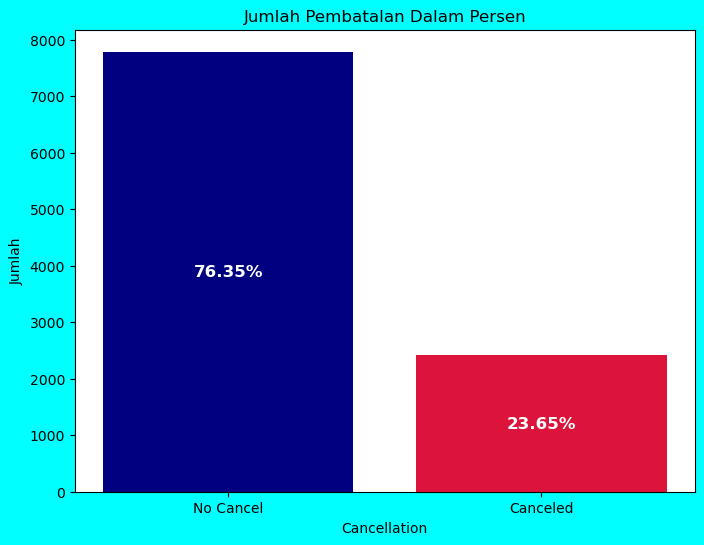

In [11]:
# Barplot
plt.figure(figsize=(8,6), facecolor='aqua')
bars = plt.bar(['No Cancel', 'Canceled'], jumlah_cancel, color=['navy', 'crimson'])

# Anotasi untuk persentase
for bar, persentase in zip(bars, persentase_cancel):
     plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{persentase:.2%}', ha='center', va='center', fontsize=12, fontweight='bold', color='white')

# Label dan judul
plt.title('Jumlah Pembatalan Dalam Persen')
plt.xlabel('Cancellation')
plt.ylabel('Jumlah')
plt.show()

Jumlah tamu yang melakukan cancel sebanyak 23,65% dari total seluruh pesanan. Persentase ini cukup tinggi jika dibandingkan dengan rata-rata cancel dari hotel di Portugal sebesar [10%](https://www.appointmentreminders.com/how-is-a-no-show-rate-calculated/) 

Sekarang kita ingin mengetahui categori tamu seperti apa yang paling banyak melakukan cancel.

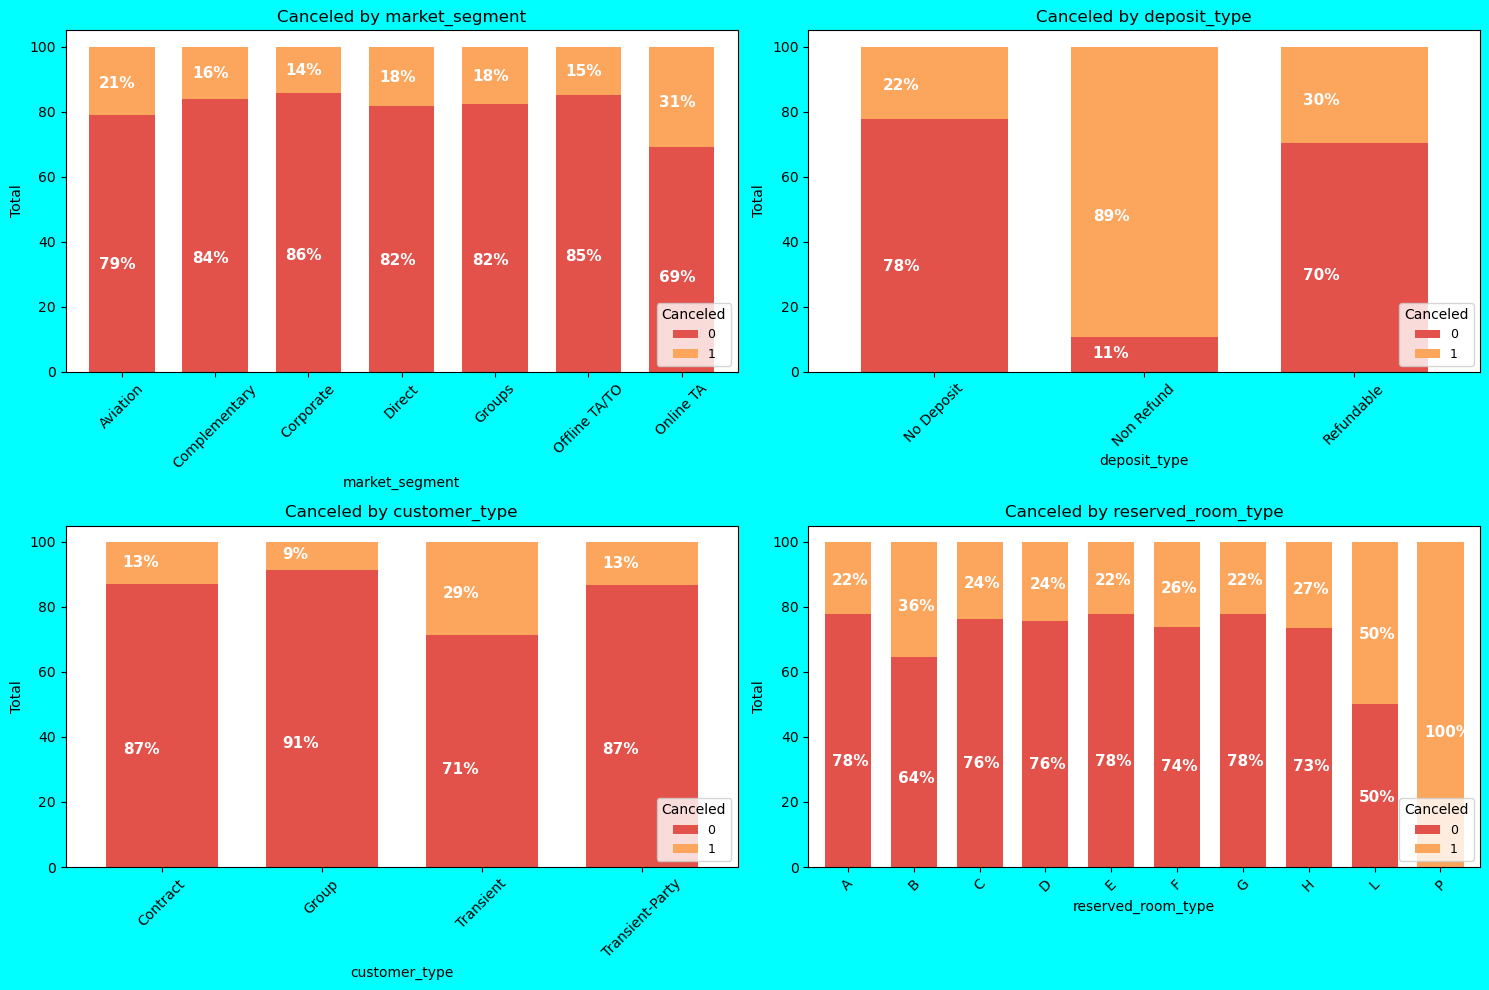

In [12]:
plt.figure(figsize=(15, 10), facecolor='aqua')
plotnumber = 1

# Membuat stackbar untuk melihat perbandingan antara Cancel dan No Cancel ad tiap categorical feature
for feature in categorical:
    if feature == 'country':
        continue
    
    groupby_table = hotel_data.groupby([feature,'is_canceled']).size().unstack()

    def show(height):
        if height > 0:
            return '{:.0f}%'.format(height)
        else:
            return '' 
    ax = plt.subplot(2, 2, plotnumber)
    
    (groupby_table.T * 100.0 / groupby_table.T.sum()).T.plot(kind='bar',
                                                            width=0.7,
                                                            stacked=True,
                                                            rot=0, 
                                                            ax=ax,
                                                            color=sns.color_palette('Spectral'))

    ax.legend(loc='lower right', prop={'size':9}, title='Canceled')
    ax.set_ylabel('Total')
    ax.set_title(f'Canceled by {feature}', size=12)

    # menambahkan label data pada stacked bar chart
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate(show(height), (p.get_x() + 0.15 * width, p.get_y() + 0.4 * height),
                    color='white',
                    weight='bold',
                    size=11)
    
    plt.tight_layout()
    plt.xticks(rotation=45)
    plotnumber += 1

***Insight*** :
- Tamu yang melakukan pesanan dari Travel Agency Online paling banyak melakukan pembatalan
- Tipe pemesanan yang tidak dapat diuangkan kembali (Refund) memiliki tingkat pembatalan tertinggi sebesar 89%, hal ini menunjukan bahwa kebanyakan tamu masih ragu dengan pesanan yang mereka buat sehingga memilih untuk membatalkan booking jika itu tidak dapat di refund.
- Tamu individu paling banyak melakukan pembatalan karena tidak terikat dengan contract atau resiko lain yang menghalangi mereka untuk melakukan pembatalan.
-  Tamu yang melakukan reservasi untuk kamar dengan tipe P semuanya melakukan pembatalan, sedangkan untuk kamar dengan tipe L setengah dari reservasi melakukan pembatalan

Dan jika kita ingin melihat tamu dari negara mana yang memiliki jumlah cancel terbanyak adalah sebagai berikut

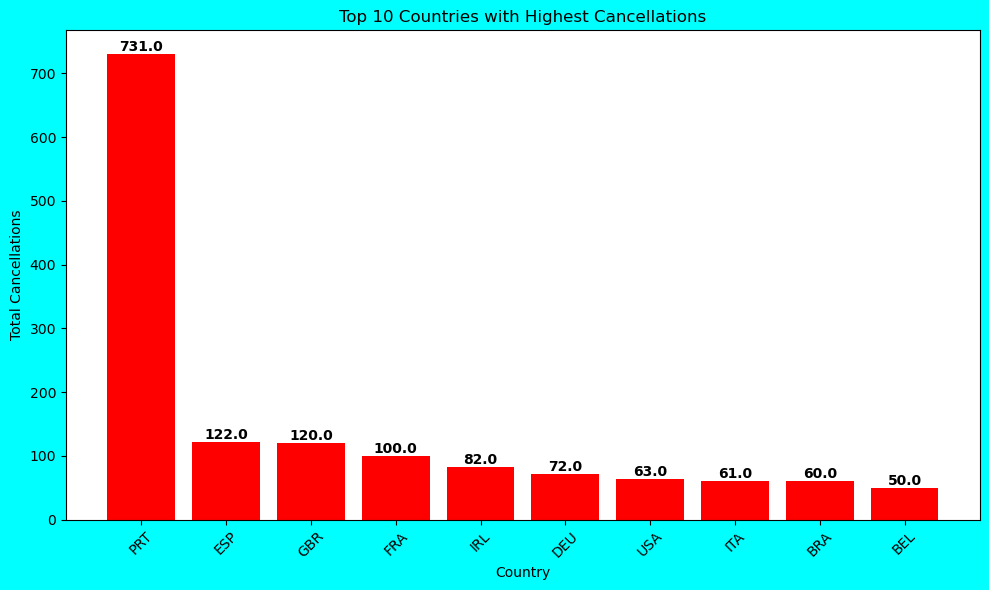

In [13]:
grouped = hotel_data.groupby('country')['is_canceled'].sum().reset_index()
sorted_countries = grouped.sort_values(by='is_canceled', ascending=False)

top_10_countries = sorted_countries.head(10)

# Barplot untuk 10 Negara dengan tingkat cancel tertinggi
plt.figure(figsize=(10, 6),facecolor='aqua')
bars = plt.bar(top_10_countries['country'], top_10_countries['is_canceled'], color='red')
plt.xlabel('Country')
plt.ylabel('Total Cancellations')
plt.title('Top 10 Countries with Highest Cancellations')
plt.xticks(rotation=45)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}', va='bottom', ha='center', color='black',fontweight = 'bold')

plt.tight_layout()
plt.show()

***Insight***:
Meskipun tamu dari Portugal merupakan tamu terbanyak tapi disaat bersamaan mereka juga menjadi tamu yang paling sering melakukan pembatalan

Sekarang kita akan mencoba mencari tahu bagaimana hubungan antara numerical feature dan jumlah cancel

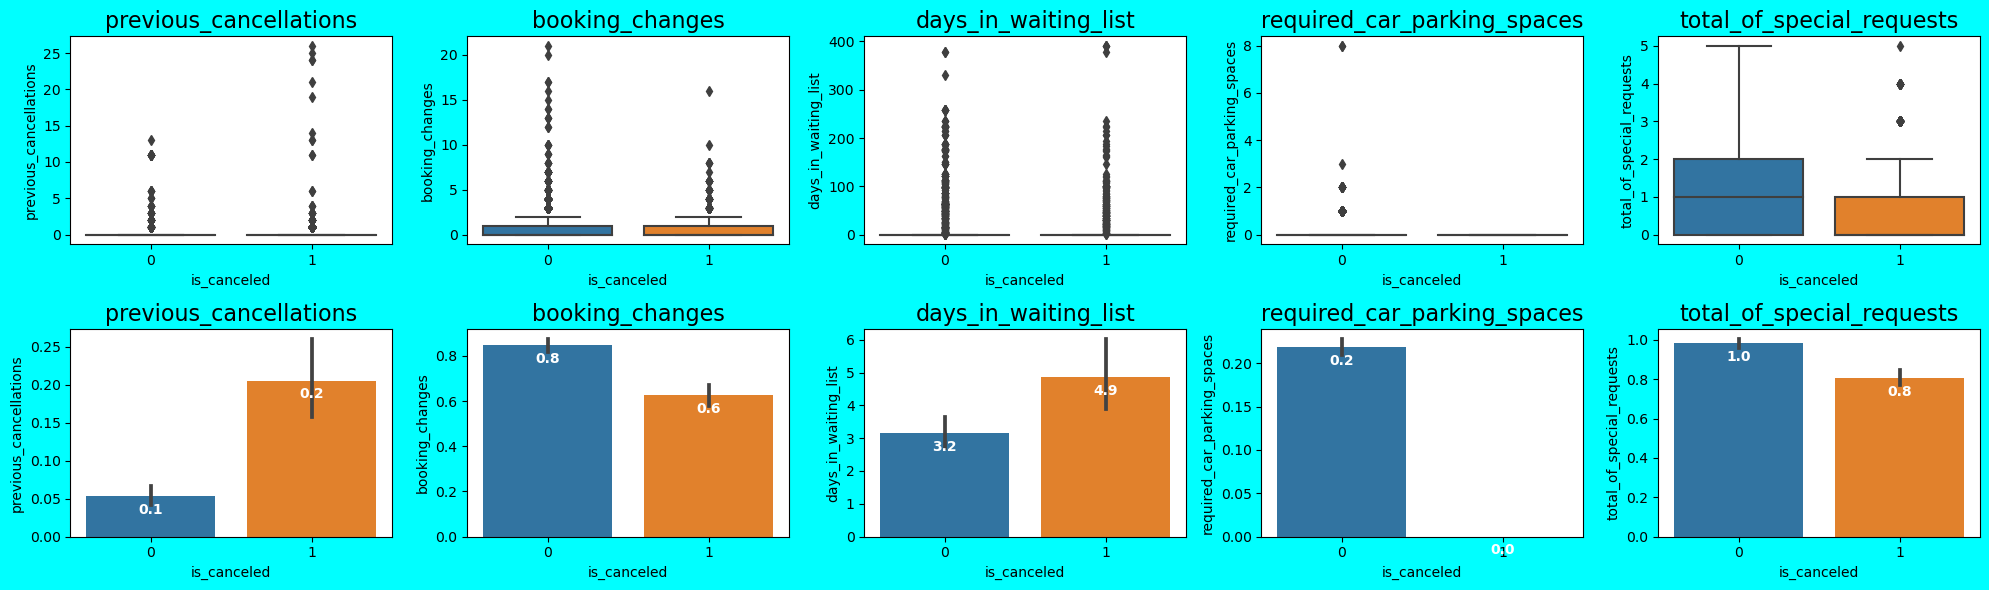

In [14]:
plt.figure(figsize=(20, 6), facecolor='aqua')
plotnumber = 1

for feature in numerical:
    if feature == 'is_canceled':
        continue
    ax = plt.subplot(2,5, plotnumber)
    sns.boxplot(y=feature, x='is_canceled', data=hotel_data)
    plt.title(feature, fontsize=16)
    plt.tight_layout()
    plotnumber = plotnumber + 1

for feature in numerical:
    if feature == 'is_canceled':
        continue
    ax = plt.subplot(2,5, plotnumber)
    sns.barplot(y=feature, x='is_canceled', data=hotel_data)
    plt.title(feature, fontsize=16)
    container = ax.containers[0]
    ax.bar_label(container , labels=[f'{x:,.1f}' for x in container.datavalues], label_type='edge', padding = -15, color="white", fontweight='bold')
    plt.tight_layout()
    plotnumber = plotnumber + 1

***Insight*** :
- Disini kita dapat melihat bahwa tamu yang sebelumnya pernah melakukan pembatalan lebih dari 10 kali cenderung untuk membatalkan pesanannya (cancel).
- Tamu yang telah melakukan perubahan pesanan lebih dari 15 kali cenderung untuk melanjutkan pesanannya, dan terlihat kalau tamu menyukai hotel yang memberikan mereka fleksibilitas dalam mengatur jadwal mereka sendiri.
- Semakin lama seorang tamu beradaa dalam daftar tunggu maka akan semakin besar kemungkinan mereka untuk membatalkan pesanannya
- Tidak ada korelasi antara jumlah parkir yang tersedia dengan tingkat pembatalan


Setelah mengetahui gambaran umum terkait tingkat cancelation sekarang kita akan coba melihat tiap feature categorical

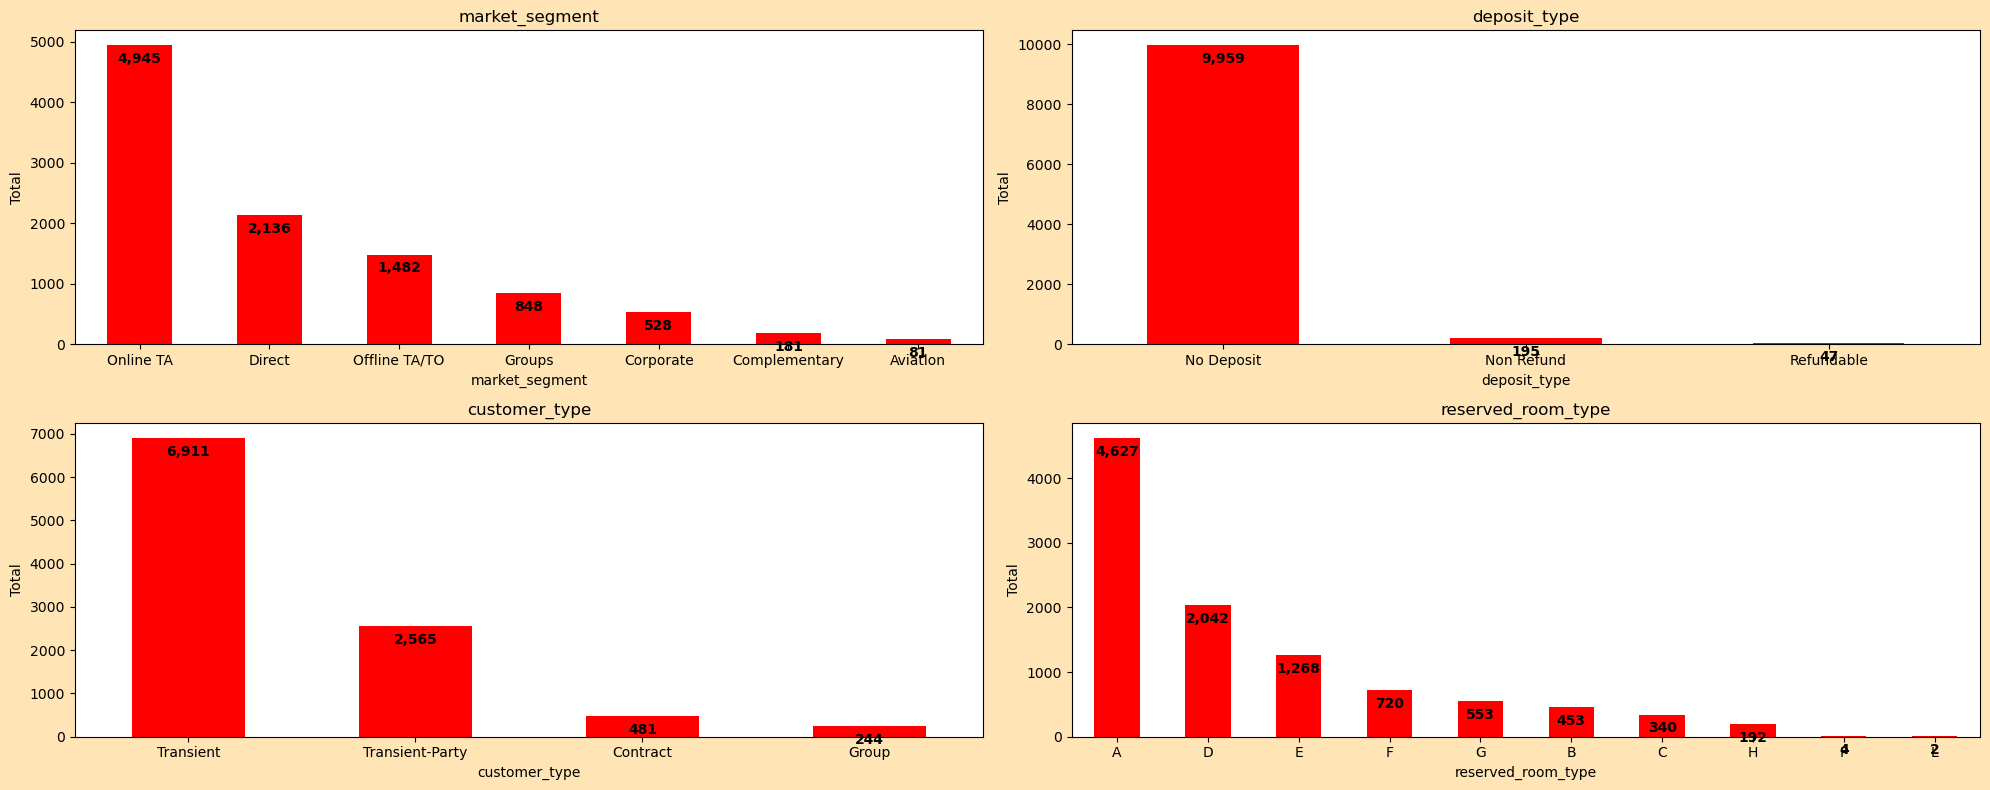

In [15]:
plt.figure(figsize=(20,8), facecolor='moccasin')
plotnumber = 1

for feature in categorical :
    if feature == 'country':
        continue
    ax = plt.subplot(2,2, plotnumber)
    ax = hotel_data[feature].value_counts().plot(kind = 'bar', rot = 0, color=['red'])
    
    plt.ylabel('Total')
    plt.xlabel(feature)
    plt.title(feature, fontsize=12)
    container = ax.containers[0]
    ax.bar_label(container , labels=[f'{x:,.0f}' for x in container.datavalues], label_type='edge', padding = -15, color="black",fontweight = 'bold')
    plt.tight_layout()
    # plt.xticks(rotation=45)
    
    plotnumber += 1
plt.show()

***Insight***:

Setelah melihat persebaran data pada categorical feature, sekarang kita akan melihat distribusi pada numerical feature

## Outlier

In [16]:
list_lower = []
list_upper = []
number_lower = []
number_inside = []
number_upper = []

for feature in numerical: 
    IQR = hotel_data[feature].quantile(0.75) - hotel_data[feature].quantile(0.25)
    lower_fence = hotel_data[feature].quantile(0.25) - 1.5*IQR
    upper_fence = hotel_data[feature].quantile(0.75) + 1.5*IQR
    list_lower.append(lower_fence)
    list_upper.append(upper_fence)
    number_lower.append(len(hotel_data[hotel_data[feature]<lower_fence]))
    number_inside.append(len(hotel_data[(hotel_data[feature]>=lower_fence) & (hotel_data[feature]<=upper_fence)]))
    number_upper.append(len(hotel_data[hotel_data[feature]>upper_fence]))

outliers = pd.DataFrame({
    'Kolom' : numerical,
    'Lower' : list_lower,
    'Upper' : list_upper,
    '# Lower' : number_lower,
    '# Inside' : number_inside,
    '# Upper' : number_upper,
})

outliers

,Kolom,Lower,Upper,# Lower,# Inside,# Upper
0,previous_cancellations,0.0,0.0,0,9811,390
1,booking_changes,-1.5,2.5,0,9377,824
2,days_in_waiting_list,0.0,0.0,0,9736,465
3,required_car_parking_spaces,0.0,0.0,0,8534,1667
4,total_of_special_requests,-3.0,5.0,0,10201,0
5,is_canceled,0.0,0.0,0,7788,2413


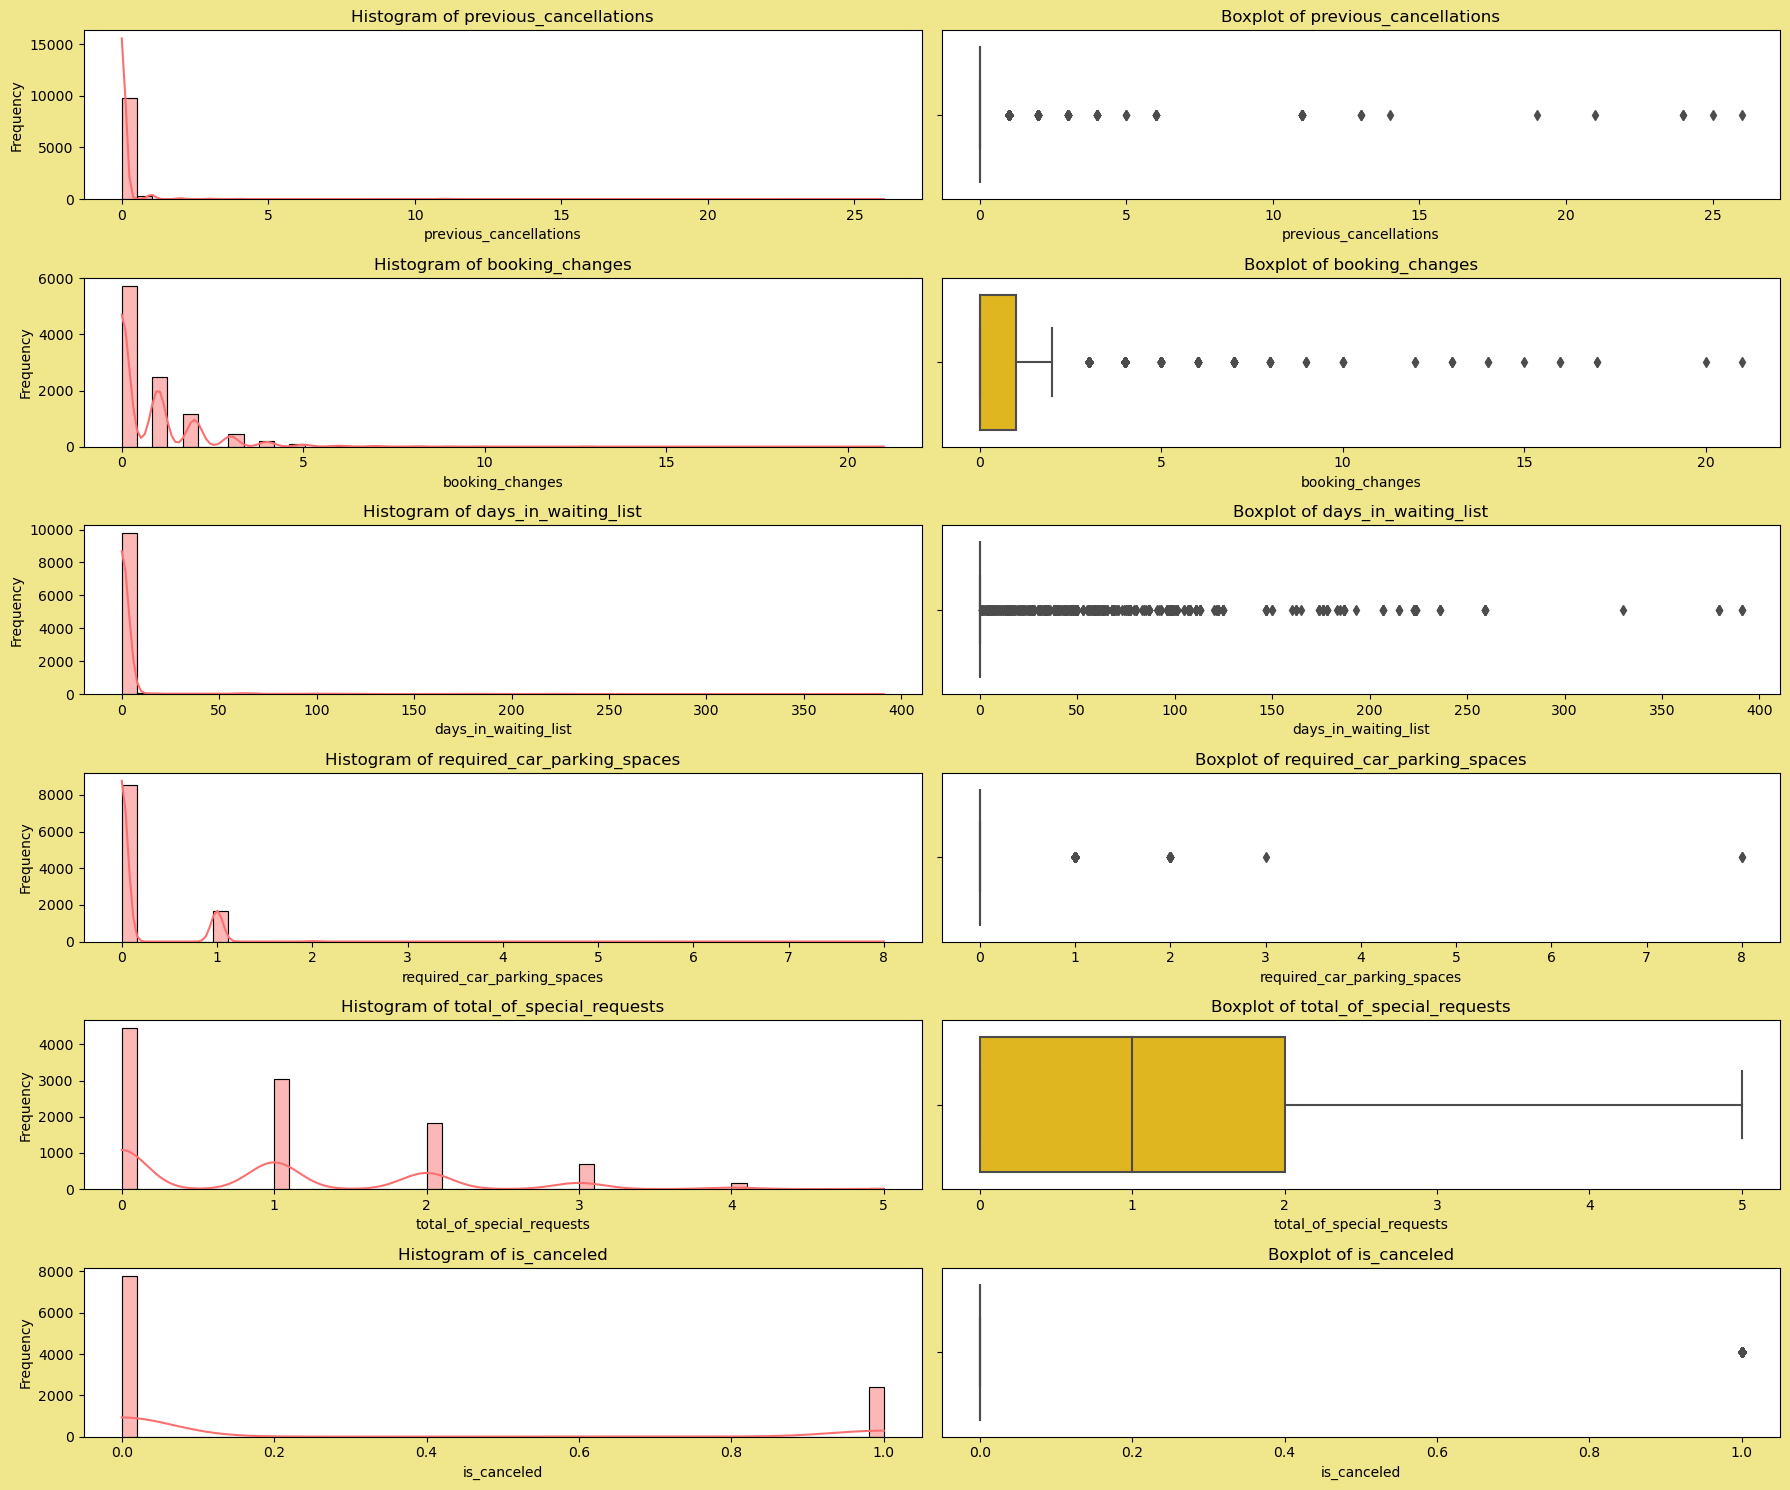

In [17]:
plt.figure(figsize=(18, 15), facecolor='khaki')

for index, col in enumerate(numerical):
    # Histogram
    plt.subplot(len(numerical), 2, index * 2 + 1)
    sns.histplot(hotel_data[col], kde=True, color='#FA7070', bins=50)
    plt.title(f'Histogram of {col}', size=12)
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(len(numerical), 2, index * 2 + 2)
    sns.boxplot(x=hotel_data[col], color='#FFC700')
    plt.title(f'Boxplot of {col}', size=12)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

In [18]:
# Cek persentase outlier untuk setiap numerical feature
def calculate_outliers_1(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

outlier_data = []

numerical = [var for var in hotel_data.columns if hotel_data[var].dtypes != 'object']

for column in numerical:
    if column == 'is_canceled' :
        continue
    outlier_result, lower_bound, upper_bound = calculate_outliers_1(hotel_data, column)
    total_outlier = len(outlier_result)
    outlier_percentage = round(total_outlier / len(hotel_data[column]) * 100, 2)
    outlier_data.append([column, total_outlier, outlier_percentage, lower_bound, upper_bound])

outlier_df = pd.DataFrame(outlier_data, columns=["Column", "Total Outliers", "Percentage (%)", "Lower Bound", "Upper Bound"])

display(outlier_df)


,Column,Total Outliers,Percentage (%),Lower Bound,Upper Bound
0,previous_cancellations,390,3.82,0.0,0.0
1,booking_changes,824,8.08,-1.5,2.5
2,days_in_waiting_list,465,4.56,0.0,0.0
3,required_car_parking_spaces,1667,16.34,0.0,0.0
4,total_of_special_requests,0,0.00,-3.0,5.0


***insight*** :
Terdapat 3 kategori outlier yang ada dalam dataset ini :
- **Mild Outlier** (<5%) = `previous_cancellations` dan `days_in_waiting_list`
- **Moderate Outlier** (8% - 10%) = `booking_changes`
- **Extreme Outlier** (>10%) = `required_car_parking_spaces`

Dari jumlah outlier yang ada kita dapat melihat bahwa `required_car_parking_spaces` membutuhkan penanganan lebih lanjut

## Corelation

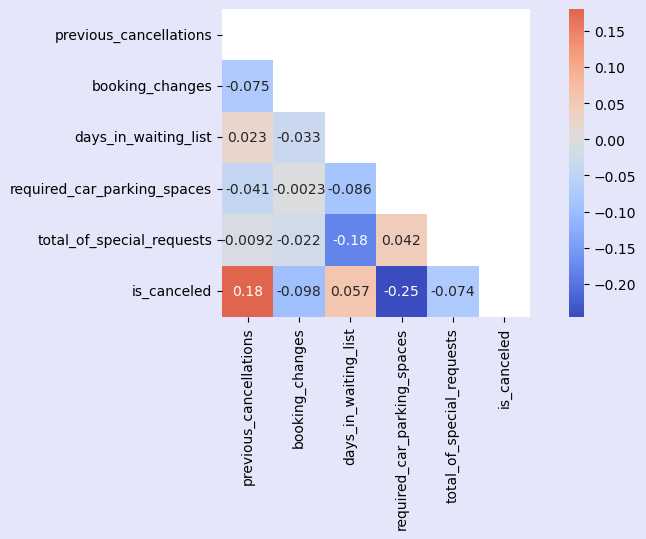

In [19]:
num_only = pd.DataFrame(hotel_data.select_dtypes(include=['int','float']))
plt.figure(figsize=(10,4),facecolor='lavender')
corr_num = num_only.corr(method='spearman')
matrix = np.triu(corr_num)
sns.heatmap(data=corr_num, annot=True, cmap='coolwarm', center=0, mask = matrix, square='True')
plt.show()

***insight:***

Berdasarka hasil korelasi ini tidak terlihat ada feature yang memiliki korelasi kuat (> ±0,5), korelasi terbesar dimiliki antara `is_canceled` dengan `required_car_parking_space`, korelasi tersebut bernilai negatif yang artinya jika jumlah no cancel pada `is_cancel` meningkat maka jumlah car parking di `required_car_parking_space` akan menurun.

# **Data Preprocessing**

## Feature Engineering

Disni kita akan melakukan feature selection yang nantinya akan digunakan dalam modeling.

Adapun feature yang akan kita drop atau modifikasi adalah feature yang memiliki High Cardinality.
Melakukan drop atau modifikasi pada feature yang memiliki High Cardinality berguna untuk :
- mempermudah interpretasi
- mencegah terjadinya overfitting 
- meringankan  komputasi

In [20]:
# Mencari jumlah unique untuk setiap kolom
pd.set_option('display.max_colwidth',None)

# Data unik disetiap kolom
list_nilai_unik = []
for col in hotel_data.columns :
    list_nilai_unik.append([col, hotel_data[col].nunique()])

nilai_unik = pd.DataFrame(columns=['Nama Kolom','Jumlah Unik'],
                        data=list_nilai_unik)
nilai_unik

,Nama Kolom,Jumlah Unik
0,country,162
1,market_segment,7
2,previous_cancellations,15
3,booking_changes,19
4,deposit_type,3
5,days_in_waiting_list,115
6,customer_type,4
7,reserved_room_type,10
8,required_car_parking_spaces,5
9,total_of_special_requests,6


Disini terlihat bahwa ada 2 kolom yang memiliki High Cardinality yaitu `country` dan `days_in_waiting_list`. Pada kolom `country` akan kurangi nilai uniknya dengan hanya menampilkan 10 negara dengan jumlah kemunculan paling sering dan negara lain yang tidak termasuk kedalam itu akan diganti dengan others, sedangkan kita akan mempertahankan kolom `days_in_waiting_list`

In [21]:
country_counts = hotel_data['country'].value_counts()

top_10_countries = country_counts.nlargest(10).index

# Ganti negara selain top 10 dengan 'others'
hotel_data['country'] = hotel_data['country'].apply(lambda x: x if x in top_10_countries else 'others')



## Collinearity

In [22]:
def calculate_vif(data):
    vif = pd.DataFrame()
    vif['Feature'] = data.columns
    vif['VIF'] = [variance_inflation_factor(data.dropna(), i) for i in range(len(data.columns))]

    return vif.sort_values('VIF', ascending=False)

Kita akan melakukan pengujian berulang hingga diperoleh nilai VIF < 10.

In [23]:
vif_hotel = calculate_vif(hotel_data[numerical])
dropped_columns = []

for i in range(len(vif_hotel)):
    if vif_hotel.iloc[0, -1] < 10:
        break
    else:
        dropped_columns.append(vif_hotel.iloc[0, 0])
        vif_hoetl = calculate_vif(hotel_data[numerical].drop(columns=dropped_columns))

In [24]:
vif_hotel

,Feature,VIF
4,total_of_special_requests,1.276784
1,booking_changes,1.166955
5,is_canceled,1.135375
3,required_car_parking_spaces,1.110898
0,previous_cancellations,1.015759
2,days_in_waiting_list,1.013276


## Cek Missing Value dan Duplicated Value

In [25]:
display(f'Data ini memiliki baris, kolom sebanyak : {hotel_data.shape}')
print ('Missing Value')
display(hotel_data.isna().sum())
display(f"Jumlah duplikasi data: {hotel_data[hotel_data.duplicated()].shape}")
display(f'Persentase sebesar {(hotel_data.duplicated().sum())/len(hotel_data)*100}%')

'Data ini memiliki baris, kolom sebanyak : (10201, 11)'

Missing Value


country                        0
market_segment                 0
previous_cancellations         0
booking_changes                0
deposit_type                   0
days_in_waiting_list           0
customer_type                  0
reserved_room_type             0
required_car_parking_spaces    0
total_of_special_requests      0
is_canceled                    0
dtype: int64

'Jumlah duplikasi data: (3264, 11)'

'Persentase sebesar 31.9968630526419%'

In [26]:
hotel_data.drop_duplicates(inplace=True)

## Imbalance Data

In [27]:
# Check the class distribution before remove duplicate
from collections import Counter

print("Class distribution:", Counter(hotel_data['is_canceled']))
print(f"Class distribution Percentage:", {k: v / len(hotel_data) * 100 for k, v in (Counter(hotel_data['is_canceled'])).items()})


Class distribution: Counter({0: 5300, 1: 1637})
Class distribution Percentage: {0: 76.40190283984431, 1: 23.59809716015569}


Persentasi antara 0 : 76% dan 1 : 23% masih tergolong kedalam mild imbalance, meskipun begitu kita akan tetap menerapkan teknik ***SMOTE-NC(Synthetic Minority Over-sampling Technique for Nominal and Continuous)***.

Disini kita memilih menggnukan SMOTE-NC karena dalam dataset ini terdapat feature numeric(continous) dan juga feature categorical

<p align="center"><img src =https://www.kdnuggets.com/wp-content/uploads/wijaya_7_smote_variations_oversampling_16.jpg>

In [28]:
hotel_data.dtypes

country                        object
market_segment                 object
previous_cancellations          int64
booking_changes                 int64
deposit_type                   object
days_in_waiting_list            int64
customer_type                  object
reserved_room_type             object
required_car_parking_spaces     int64
total_of_special_requests       int64
is_canceled                     int64
dtype: object

In [29]:
categorical_features_indices = [0, 3, 5, 6, 9, 10]

sekoteng = SMOTENC(random_state=0, categorical_features=categorical_features_indices)

## Handling Outliers

In [30]:
outlier_df

,Column,Total Outliers,Percentage (%),Lower Bound,Upper Bound
0,previous_cancellations,390,3.82,0.0,0.0
1,booking_changes,824,8.08,-1.5,2.5
2,days_in_waiting_list,465,4.56,0.0,0.0
3,required_car_parking_spaces,1667,16.34,0.0,0.0
4,total_of_special_requests,0,0.00,-3.0,5.0


Menggunakan winsorizing untuk `previous_cancellations`, `booking_changes`, `days_in_waiting_list` dan `required_car_parking_spaces`

In [31]:
# melakuakn fungsi winsorizing

def winsorize_with_pandas(s, limits):
    return s.clip(lower=s.quantile(limits[0]), 
                  upper=s.quantile(1-limits[1]))

In [32]:
class HandlingOutliers(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns
        return self  
    
    def transform(self, X, y=None):
        data = X.copy()
        cols_to_winsorize = ['previous_cancellations', 'booking_changes', 'days_in_waiting_list','required_car_parking_spaces']
        data[cols_to_winsorize] = data[cols_to_winsorize].apply(winsorize_with_pandas, args=([0.01, 0.01],))
        return data
    
    def set_output(self, transform: Literal['default', 'pandas']):
        return super().set_output(transform=transform)

## Encoding

In [33]:
categorical =  [feature for feature in hotel_data.columns if hotel_data[feature].dtypes == 'object']

numerical = [feature for feature in hotel_data.describe().columns]


In [34]:
# menampilkan jumlah unik dan unique values untuk setiap kolom
pd.set_option('display.max_colwidth', None)
# data uni di tiap kolom
listItem = []
for col in categorical :
    listItem.append( [col, hotel_data[col].nunique(), hotel_data.sort_values(col)[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Values'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Values
0,country,11,"[BEL, BRA, DEU, ESP, FRA, GBR, IRL, ITA, PRT, USA, others]"
1,market_segment,7,"[Aviation, Complementary, Corporate, Direct, Groups, Offline TA/TO, Online TA]"
2,deposit_type,3,"[No Deposit, Non Refund, Refundable]"
3,customer_type,4,"[Contract, Group, Transient, Transient-Party]"
4,reserved_room_type,10,"[A, B, C, D, E, F, G, H, L, P]"


1. `country`: Binary encoding.
1. `market_segment`: One-hot encoding.
1. `deposit_type`: One-hot encoding.
1. `customer_type`: One-hot encoding.
1. `reserved_room_type`: binary encoding.


In [35]:
transformer = ColumnTransformer([
    ('one_hot_encoder', OneHotEncoder(drop='first',handle_unknown='ignore'), ['market_segment', 'deposit_type', 'customer_type']),
    ('binary_encoder', BinaryEncoder(), ['reserved_room_type','country']),
    # ('passthrough', 'passthrough', ['country'])
], remainder='passthrough')

Disiini kita akan menggunakan Robust Scaler karena dataset memiliki outlier dan tidak terdistribusi normal.

In [36]:
scaler = RobustScaler()


In [37]:
Pipeline([
    ('outlier', HandlingOutliers()),
    ('transformer', transformer),
    ('scaler', scaler),
    ('resampler', sekoteng),
])

Pipeline(steps=[('outlier', HandlingOutliers()),
                ('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['market_segment',
                                                   'deposit_type',
                                                   'customer_type']),
                                                 ('binary_encoder',
                                                  BinaryEncoder(),
                                                  ['reserved_room_type',
                                                   'country'])])),
                ('scaler', RobustScaler()),
                ('resampler',
                 SMOTENC(categorical_features=[0, 3, 5, 6, 9, 10],
                         random_state=0))])

Tahap preprocessing ini dimulai dari Handling Outlier dengan menggunakan metode ***Winsorizing***, kemudian masuk kedalam tahap encoding. Pada tahap encoding ini kita merubah dari bentuk kategorikal menjadi numerical, pada tahap ini kita menjalankan 2 metode secara bersamaan yaitu ***OneHot encoding dan Binary encoding***, dengan detail sebagai berikut :
- OneHot Encoding : `market_segment`, `deposit_type`, `customer_type`
- Binary Encoding : `reserved_room_type`,`country`

Setelah melakukan encoding kemudian akan dilakukan scaling menggunakan ***Robust Scaler***. Karena data kita berada dalam kedaan mild imbalance (Target 0: 76%, 1: 24%) maka kita akan handling imbalance menggunakan teknik ***SMOTE-NC(Synthetic Minority Over-sampling Technique for Nominal and Continuous)*** karena didalam kasus ini terdapat feature yang bersifat numerical dan categorical

## Define X and Y

In [38]:
# define fetures and target
X = hotel_data.drop(columns = ['is_canceled'])
y = hotel_data['is_canceled']

# data splitting
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=28, test_size=0.2, stratify=y)

Pengecekan distribusi antara train dan test

In [39]:
persentase_cancel_train = y_train.value_counts() / len(y_train)
persentase_cancel_test = y_test.value_counts() / len(y_test)

display (persentase_cancel_train)
display (persentase_cancel_test)

is_canceled
0    0.764102
1    0.235898
Name: count, dtype: float64

is_canceled
0    0.763689
1    0.236311
Name: count, dtype: float64

Disini terlihat bahwa proporsi target pada data train dan test dalam posisi yang sama.

# Modeling

Pada tahap ini kita akan define seluruh model yang akan kita coba pada project kali ini, penjelasan singkat dari model yang akan kita gunakana adalah sebagai berikut :

|Nama Model|Definition|
|---|---|
|Logistic Regresion|Merupakan model statistik yang digunakan untuk memprediksi probabilitas dari kategori biner terklasifikasi, berdasarkan satu atau lebih fitur independen.|
|K-Nearest Neighbor(KNN)|Algoritma yang digunakan untuk klasifikasi dan regresi yang berfungsi dengan mencari sejumlah k data titik terdekat (neighbors) yang sudah diklasifikasikan untuk menentukan kategori dari titik baru.|
|Decision Tree|Model prediktif yang menggunakan struktur pohon untuk mengambil keputusan berdasarkan fitur input. Setiap node internal mewakili tes pada suatu atribut, setiap cabang mewakili hasil tes, dan setiap daun mewakili label kelas atau nilai yang diprediksi.|
|Random Forest|Metode ensemble yang menggunakan banyak decision trees untuk meningkatkan akurasi prediksi. Setiap tree dibangun dari subset acak dari data, dan hasil akhir diambil dari agregasi hasil semua tree (biasanya melalui voting untuk klasifikasi atau rata-rata untuk regresi).|
|Adaptive Boosting (AdaBoost)|Metode boosting yang menggabungkan beberapa weak classifiers untuk membentuk strong classifier. Algoritma ini memberikan bobot lebih pada instance yang salah klasifikasi sehingga classifier berikutnya fokus pada kasus-kasus yang sulit.|
|Gradient Boost|Teknik boosting yang menggabungkan model prediktif lemah, biasanya decision trees, dengan cara yang iteratif dan bertahap untuk mengoptimalkan fungsi loss melalui gradiennya.|
|Categorical Boosting (CatBoost)|Algoritma boosting yang dirancang khusus untuk menangani data kategorikal dengan baik dan menghindari overfitting, serta memanfaatkan pengurutan observasi untuk meningkatkan kecepatan dan akurasi.|
|Extreme Gradient Boosting (XGBoost)| Implementasi optimisasi dari gradient boosting yang memiliki keunggulan dalam kecepatan, efisiensi, dan kinerja, sering digunakan dalam kompetisi machine learning.|
|Light Gradient Boosting Machine (LightGBM)| Algoritma boosting yang efisien dan cepat yang menggunakan teknik histogram-based learning untuk mengurangi kompleksitas waktu pelatihan, serta mendukung paralelisasi dan pemotongan data besar.|

In [40]:
## Model yang digunakan
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
ada = AdaBoostClassifier(random_state=0)
grad = GradientBoostingClassifier(random_state=0)
cat = CatBoostClassifier(verbose=False,random_state=0)
xgb = XGBClassifier(random_state=0)
lgbm = LGBMClassifier(random_state=0)

### Default Hyperparameter 

#### Cross Validation

In [41]:
# Pemilihan model, dengan menggunakan 5 fold
models = [logreg, knn, tree, rf, ada, grad, cat, xgb, lgbm]
skfold = StratifiedKFold(n_splits = 5)

recall_mean_with_sampling = []
recall_std_with_sampling = []
recall_mean_without_sampling = []
recall_std_without_sampling = []

# Mencari model terbaik berdasarkan rerata recall score terkecil dan std terkecil
# with oversampling 
for algoritma in models:

    model_pipe = Pipeline([
        ('outlier', HandlingOutliers()),
        ('transformer', transformer),
        ('scaler', scaler),
        ('resampler', sekoteng),
        ('model', algoritma)
    ])


    model_cv = cross_val_score(
        model_pipe,                
        X_train,                    
        y_train, 
        cv = skfold,
        error_score='raise', 
        scoring = 'recall'
        )

    recall_mean_with_sampling.append(model_cv.mean())
    recall_std_with_sampling.append(model_cv.std())
    
# without oversampling 
for algoritma in models:

    model_pipe = Pipeline([
        ('outlier', HandlingOutliers()),
        ('transformer', transformer),
        ('scaler', scaler),
        # ('resampler', sekoteng),
        ('model', algoritma)
    ])


    model_cv_1 = cross_val_score(
        model_pipe,                
        X_train,                    
        y_train, 
        cv = skfold,
        error_score='raise', 
        scoring = 'recall'
        )

    recall_mean_without_sampling.append(model_cv_1.mean())
    recall_std_without_sampling.append(model_cv_1.std())
    

[LightGBM] [Info] Number of positive: 3392, number of negative: 3392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1121
[LightGBM] [Info] Number of data points in the train set: 6784, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 3392, number of negative: 3392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1221
[LightGBM] [Info] Number of data points in the train set: 6784, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [42]:
# Perbandingan recall score pada tiap algoritma
pd.DataFrame({
    'model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'AdaBoost', 'GradienBoost', 'CatBoost', 'XGBoost', 'LightGBM'],
    'mean_recal_with_sampling': recall_mean_with_sampling,
    'std_recal_with_sampling': recall_std_with_sampling,
    'mean_recal_without_sampling': recall_mean_without_sampling,
    'std_recal_without_sampling': recall_std_without_sampling,
}).sort_values('mean_recal_with_sampling', ascending=False)

,model,mean_recal_with_sampling,std_recal_with_sampling,mean_recal_without_sampling,std_recal_without_sampling
0,Logistic Regression,0.737981,0.023090,0.306353,0.021814
5,GradienBoost,0.652379,0.036410,0.256685,0.004435
4,AdaBoost,0.637159,0.024079,0.319356,0.021456
1,KNN,0.598918,0.017860,0.297166,0.024215
8,LightGBM,0.474382,0.031606,0.336899,0.017470
6,CatBoost,0.458352,0.020888,0.311705,0.019075
7,XGBoost,0.452242,0.013815,0.347612,0.030081
3,Random Forest,0.343792,0.015125,0.289562,0.019378
2,Decision Tree,0.307885,0.019224,0.288023,0.028190


***Insight :***

Logistic Regression memiliki mean recall score tertinggi yaitu **0.73** dengan standard deviation sebesar 0.023. Hal ini menunjukkan bahwa Logistic Regression konsisten memberikan performa yang tinggi dan stabil untuk dataset ini.

Dari semua model juga terlihat bahwa nilai recall yang menggunakan teknik SMOTE-NC memberikan hasil yang jauh lebih baik dengan model tanpa oversampling. Hal ini membuktikan bahwa SMOTE-NC mampu meningkatkan performa model dan juga meminimalisir False Negative (Tamu yang diprediksi tidak cancel padahal sebenarnya melakukan cancel), dengan hasil ini maka kita akan memilih model yang menggunakan oversampling.

#### TRAIN & TEST DATA

In [43]:
models = [logreg, knn, tree, rf, ada, grad, cat, xgb, lgbm]
score_recal_test = []
score_recal_train = []

def y_pred_func(model):
    estimator = Pipeline([
        ('outlier', HandlingOutliers()),
        ('transformer', transformer),
        ('scaler', scaler),
        ('resampler', sekoteng),
        ('model', model)
    ])
    
    estimator.fit(X_train,y_train)
    return estimator

for model in models:
    estimator_model = y_pred_func(model)
    y_pred_test = estimator_model.predict(X_test)
    y_pred_train = estimator_model.predict(X_train)
    score_recal_test.append(recall_score(y_test,y_pred_test))
    score_recal_train.append(recall_score(y_train,y_pred_train))

[LightGBM] [Info] Number of positive: 4240, number of negative: 4240
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 8480, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [44]:
df = pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'AdaBoost', 'GradienBoost', 'CatBoost', 'XGBoost', 'LightGBM'],
             'Recall score (train set)': score_recal_train,
             'Recall score (validation set)': recall_mean_with_sampling,
             'Recall score (test set)': score_recal_test}).set_index('model').sort_values(by='Recall score (validation set)',ascending=False)

df

,Recall score (train set),Recall score (validation set),Recall score (test set)
model,,,
Logistic Regression,0.751719,0.737981,0.756098
GradienBoost,0.687548,0.652379,0.679878
AdaBoost,0.653934,0.637159,0.655488
KNN,0.869366,0.598918,0.603659
LightGBM,0.624905,0.474382,0.503049
CatBoost,0.554622,0.458352,0.481707
XGBoost,0.624905,0.452242,0.487805
Random Forest,0.807487,0.343792,0.307927
Decision Tree,0.552330,0.307885,0.304878


**Insight :**

**Logistic Regression** menunjukkan hasil yang konsisten baik pada train set, validasi set, maupun test. Ini menunjukkan bahwa model ini cukup baik dalam mendeteksi cancelation (class 1).

**Gradient Boost dan AdaBoot** juga menunjukkan hasil yang relatif stabil, meskipun recall-nya sedikit lebih rendah dibanding Logistic Regression. Model ini masih cukup baik dalam mendeteksi cancelation, sehingga kedua model ini akan kita coba juga untuk tuning kembali.

Sedangkan pada model lain (KNN, LightGBM, Catboost, XGBoost, Random Forest, Decision Tree) menunjukkan tanda-tanda overfitting yang signifikan. Recall pada train set sangat tinggi, tetapi turun drastis pada validasi set dan test set. 

**Kesimpulan :**

Berdasarkan hasil pengujian yang dilakukan pada seluruh jenis model maka kita akan mengambil 3 model dengan nilai tertinggi yaitu **Logistic Regression, Gradient Boost dan AdaBoost** untuk kita lakukan hyperparameter tuning.  


## **Model Building**

### **Logistic Regression**

#### Hyperparameter Tuning

Pada tuning model Logistic Regression ini kita akan menggunakan parameter sebagai berikut :

|Parameter|Range|Description|
|---|---|---|
|`C`|0 to ∞ |**by default = 1**, merupakan kebalikan dari nilai regularisasi, semakin kecil C maka menujukan regularisasi yang makin kuat, yang bisa mencegah terjadinya overfitting |
|`penalty`|l1 (lasso) and l2 (ridge)|**by default = l1** |
|`solver`|liblinear, lbfgs, newton-cg, sag, and saga|**by default = lbfgs**, algoritma yang digunakan untuk memecahkan masalah optimasi saat melatih model Logistic Regression |

In [45]:
param_grid_logreg = {
    'model__C': [0.001, 0.01, 0.1, 1, 10],  
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] 
}

valid_params = []

skf = StratifiedKFold(n_splits=5)

estimator_logreg = Pipeline([
    ('outlier', HandlingOutliers()),
    ('transformer', transformer),
    ('scaler', scaler),
    ('resampler', sekoteng),
    ('model', logreg)
])


# Hyperparameter tuning 
grid_search_logreg = GridSearchCV(
    estimator=estimator_logreg,
    param_grid=param_grid_logreg,
    cv=skf,
    scoring='recall',
    n_jobs=-1,
    verbose=2
)

grid_search_logreg.fit(X_train, y_train)

print("Best Parameters:", grid_search_logreg.best_params_)
print("Best Cross Validation Score:", grid_search_logreg.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'model__C': 0.01, 'model__penalty': 'l1', 'model__solver': 'saga'}
Best Cross Validation Score: 0.7502149688514521


Hyperparameter terbaik untuk Logistic Regression dari hasil GridSearch = `C` = 0.01, `penalty` = l1, `solver` = saga dengan recall score sebesar 0.7502. Nilai ini cendereung sama dengan nilai sebelum tuning.

In [46]:
best_est_logreg = grid_search_logreg.best_estimator_
best_est_logreg

Pipeline(steps=[('outlier', HandlingOutliers()),
                ('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['market_segment',
                                                   'deposit_type',
                                                   'customer_type']),
                                                 ('binary_encoder',
                                                  BinaryEncoder(),
                                                  ['reserved_room_type',
                                                   'country'])])),
                ('scaler', RobustScaler()),
                ('resampler',
                 SMOTENC(categorical_features=[0, 3, 5, 6, 9, 10],
                         random_state=0)),
                ('model',
                 LogisticRegression(C=0.01, penalty='l1', random_state=0,
                                    solver='saga'))])

In [47]:
best_est_logreg.fit(X_train, y_train)


# test ke train set
y_pred_train_tuned_logreg = best_est_logreg.predict(X_train)
recall_tuned_train_logreg = recall_score(y_train, y_pred_train_tuned_logreg)

# test ke test set
y_pred_test_tuned_logreg = best_est_logreg.predict(X_test)
recall_tuned_test_logreg = recall_score(y_test, y_pred_test_tuned_logreg)
                                                                         
print("Recall on Train Data using Best Params:", recall_tuned_train_logreg)
print("Recall on Test Data using Best Params:", recall_tuned_test_logreg)


Recall on Train Data using Best Params: 0.7540106951871658
Recall on Test Data using Best Params: 0.7835365853658537


Hasil setelah tuning menunjukan ada peningkatan nilai recall pada test set, dari yang sebelum tuning adalah 75,60% menjadi 78,35% setelah tuning. Terdapat peningkatan nilai recall sebesar ± 2,75%, melihat hasil ini dapat kita katakan bahwa tuning pada Logistic Regression cukup berhasil.

#### Model Evaluation

In [48]:
def metrics_calculator(clf, X_test, y_test, model_name):
    
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, pos_label=1),
                                recall_score(y_test, y_pred, pos_label=1),
                                f1_score(y_test, y_pred, pos_label=1),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])],
                          index=['Accuracy','Precision (Class 1)','Recall (Class 1)','F1-score (Class 1)','AUC (Class 1)'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result

In [49]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    Fungsi ini bertujuan untuk meanampilkan sekaligus Confusiion Metrics, AUC curve dan Classificvation report
    '''
    sns.set(font_scale=1.2)
    
    # classification report untuk training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # classification report untuk test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]}, facecolor = 'lemonchiffon')
    
    # colormap untuk confusion matrix
    afmhot = LinearSegmentedColormap.from_list('crimson', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
    afmhot_r = afmhot.reversed()

    # Plot confusion matrix 
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=afmhot_r, ax=ax1)
    ax1.set_title(f'Confusion Matrix for {model_name}')                                     
    ax1.grid(False)
    
    # Plot AUC-ROC  
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title(f'ROC Curve for {model_name}')
    
    # Rekap hasil pengujian
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('lightsalmon')
    plt.tight_layout()
    plt.show() 


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.68      0.78      4240
           1       0.42      0.75      0.54      1309

    accuracy                           0.70      5549
   macro avg       0.66      0.72      0.66      5549
weighted avg       0.79      0.70      0.72      5549


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.67      0.77      1060
           1       0.43      0.78      0.55       328

    accuracy                           0.70      1388
   macro avg       0.67      0.73      0.66      1388
weighted avg       0.80      0.70      0.72      1388



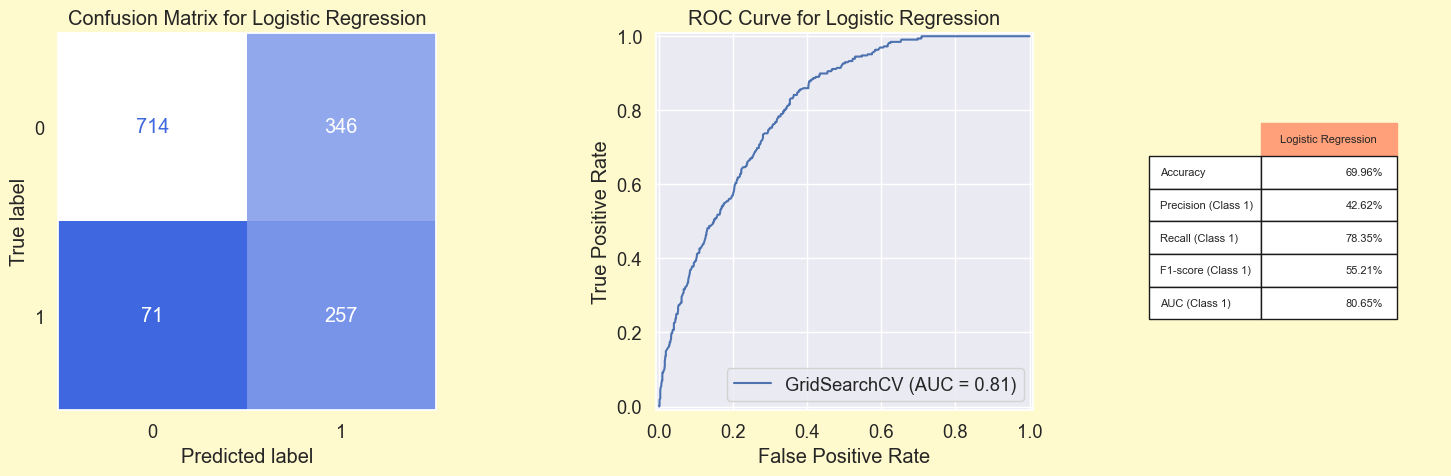

In [50]:
model_evaluation(grid_search_logreg, X_train, X_test, y_train, y_test, 'Logistic Regression')

**Insight :**

- Akurasi : 69,96% yang berarti Logistic Regression ini dengan benar memprediksi apakah sebuah booking akan dibatalkan atau tidak sebesar 70% dari seluruh total booking.
- Precision (Class 1) : 42,62%, yang menunjukan bahwa ±43% dari booking yang diprediksi akan dibatalkan memang benar-benar dibatalkan (True Positive).
- Recall (Class 1) : 78,35%, yang berarti model ini dapat mengidentifikasi sekitar 78% dari semua kasus pembatalan yang sebenarnya. 
- F1-score (Class 1) : 55.21%, merupakan rata-rata harmonic antara Precision dan Recall.
- AUC (Area Under the ROC Curve)(Class 1): 80.65%, menunjukan model dapat membedakan dengan cukup baik antara kelas positif dengan negatif, dalam kasus ini membedakan antara orang yang tidak membatalkan pesanannya (Negatif) dengan orangan yang membatalkan pesanannya (Positif). 

Confusion matrix menunjukan bahwa masih terdapat 71 pesanan yang diprediksi tidak akan melakukan pembatalan tapi ternyata membtalkan pesanan (False Negatif).
Meskipun begitu model Logistic Regression memiliki performa yang cukup baik dalam memprediksi orang yang akan melakukan pembatalan (Cancel), dan tidak overfitting karena hasil antara train dan test yang cenderung memiliki nilai cukup berdekatan. 


### **Ada Boost**

#### Hyperparameter Tuning

Pada model ini kita akan melakukan tuning dengan beberapa parameter sebagai berikut :

|Parameter|Range|Description|
|---|---|---|
|`n_estimators`|50 to 500|**by default = 50**,jumlah estimator (weak learner) yang akan dibangun dalam ensemble. Dimana kalau makin banyak estimator maka model akan menjadi semaki kompleks. |
|`learning_rate`|0.0 to 1|**by default = 1**, berguna untuk mengontrol kontribusi dari setiap estimator terhadap model akhir |


In [51]:
base_estimator = DecisionTreeClassifier()
ada =AdaBoostClassifier(estimator=base_estimator, random_state=0)

# Hyperparameter Ada Boost
param_grid_ada = {
    'model__n_estimators' : [50, 70, 90, 120, 180, 200],
    'model__learning_rate' : [0.001, 0.01, 0.1, 0.5, 1],
    'model__estimator__max_depth': [1, 2, 3, 4, 5]
}

# Pipeline for Ada
estimator_ada = Pipeline([
    ('outlier', HandlingOutliers()),
    ('transformer', transformer),
    # ('scaler', scaler),
    ('resampler', sekoteng),
    ('model', ada)
])

# Hyperparameter tuning
grid_search_ada = GridSearchCV(
    estimator_ada, 
    param_grid_ada,
    scoring= 'recall', 
    n_jobs = -1, 
    cv = 5, 
    verbose = 1
)

grid_search_ada.fit(X_train, y_train)

print("Best Parameters:", grid_search_ada.best_params_)
print("Best Cross Validation Score:", grid_search_ada.best_score_)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best Parameters: {'model__estimator__max_depth': 1, 'model__learning_rate': 0.001, 'model__n_estimators': 50}
Best Cross Validation Score: 1.0


Hyperparameter terbaik untuk Ada Boost dari hasil GridSearch =  `learning rate` = 0.001, `n_estimator` = 50 dengan recall score mencapai 1. Nilai recall dari model ini mencapai tahap dimana tidak ada False Negatif yang terdeteksi dan meningkat sangat jauh dibandingkan Nilai Recall sebelum tuning, yang akan kita pelajari selanjutnya.

In [52]:
best_est_ada = grid_search_ada.best_estimator_
best_est_ada

Pipeline(steps=[('outlier', HandlingOutliers()),
                ('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['market_segment',
                                                   'deposit_type',
                                                   'customer_type']),
                                                 ('binary_encoder',
                                                  BinaryEncoder(),
                                                  ['reserved_room_type',
                                                   'country'])])),
                ('resampler',
                 SMOTENC(categorical_features=[0, 3, 5, 6, 9, 10],
                         random_state=0)),
                ('model',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                    learning_rate=0.001, random_state=0))])

In [53]:
best_est_ada.fit(X_train, y_train)

# test ke train set
y_pred_train_tuned_ada = best_est_ada.predict(X_train)
recall_tuned_train_ada = recall_score(y_train, y_pred_train_tuned_ada)

# test ke test set
y_pred_test_tuned_ada = best_est_ada.predict(X_test)
recall_tuned_test_ada = recall_score(y_test, y_pred_test_tuned_ada)

print("Recall on Train Data using Best Params:", recall_tuned_train_ada)
print("Recall on Test Data using Best Params:", recall_tuned_test_ada)

Recall on Train Data using Best Params: 1.0
Recall on Test Data using Best Params: 1.0


Hasil model setelah tuning menunjukan ada peningkatan yang sangat signifikan, dari yang sebelum tuning hanya 65,54% menjadi 100% setelah tuning. Peningkatan ini menandakan model mendeteksi semua pembatalan, mungkin terlihat baik tapi akan kita evaluasi lebih jauh apakah sesuai dengan tujuan bisnis yang ingin kita capai.

In [54]:
score_recall_test_ada = []
score_recall_train_ada = []

y_pred_test_ada = best_est_ada.predict(X_test)
y_pred_train_ada = best_est_ada.predict(X_train)

score_recall_test_ada.append(recall_score(y_test, y_pred_test_ada))
score_recall_train_ada.append(recall_score(y_train, y_pred_train_ada))

print (f'Test : {score_recall_test_ada}')
print (f'Train : {score_recall_train_ada}')

Test : [1.0]
Train : [1.0]


#### Model Evaluation


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.25      0.41      4240
           1       0.29      1.00      0.45      1309

    accuracy                           0.43      5549
   macro avg       0.65      0.63      0.43      5549
weighted avg       0.83      0.43      0.42      5549


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.24      0.39      1060
           1       0.29      1.00      0.45       328

    accuracy                           0.42      1388
   macro avg       0.65      0.62      0.42      1388
weighted avg       0.83      0.42      0.40      1388



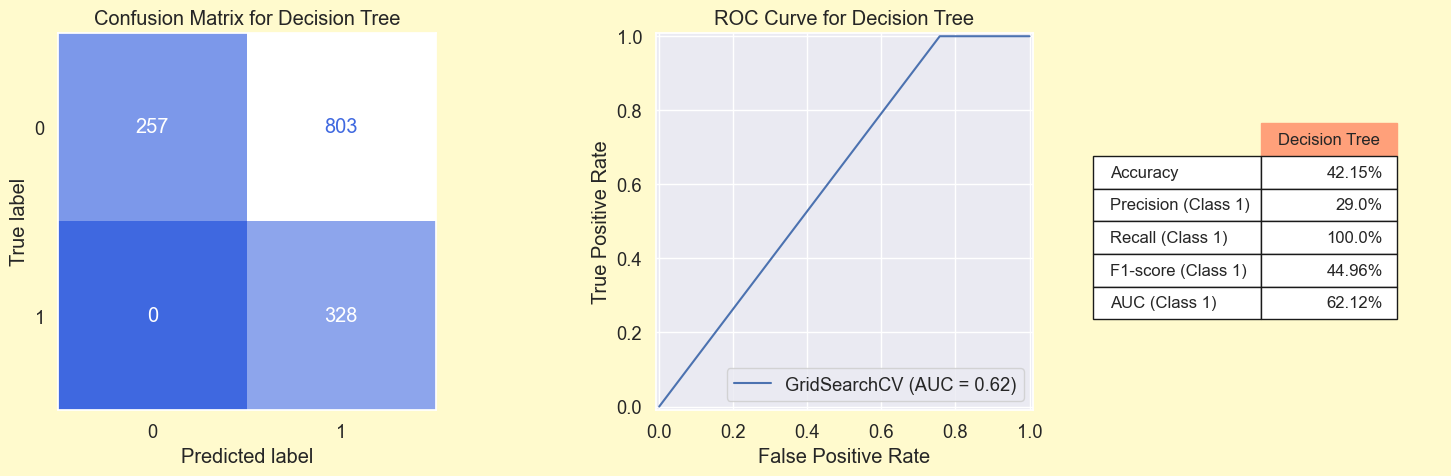

In [55]:
model_evaluation(grid_search_ada, X_train, X_test, y_train, y_test, 'Decision Tree')

- Akurasi : 42,15% yang berarti AdaBoost hanya benar memprediksi 42% dari semua prediksi. Angka ini sangat rendah untuk akurasi.
- Precision (Class 1) : 29%, yang menunjukan  hanya 29% dari semua prediksi positif (membatalkan) benar-benar membatalkan. Ini menunjukkan banyak False Positif, yaitu banyak prediksi pembatalan yang sebenarnya tidak dibatalkan.
- Recall (Class 1) : 100%, berarti semua yang sebenarnya membatalkan terdeteksi dengan benar. Tidak ada False negatif. 
- F1-score (Class 1) : 44.96%, merupakan rata-rata harmonic antara Precision dan Recall.
- AUC (Area Under the ROC Curve)(Class 1): 62.12%, menunjukan kinerja model yang cukup buruk, karena semakin mendekati 50% maka artinya model [memprediksi secara acak](https://evidentlyai.com/classification-metrics/explain-roc-curve). 

Confusion matrix menunjukan bahwa masih tidak ada False Negative, tetapi nilai False Positif mencapai 803 yang bahkan 2,4 kali lipat lebih tinggi dari nilai True Positif. Meskipun memang fokus awal adalah untuk meminimalkan nilai False Negatif, tapi jika terdapat kesalah prediksi positif sebanyak itu dapat menimbulkan resiko **Overbooking** yang dapat berdampak pada citra dan nama baik dari hotel tersebut.

Dari hasil dan metrics evaluasi yang sudah kita pelajari dapat disimpulkan bahwa memang pada model AdaBoost dapat menekan nilai False Negatif sampai tidak ada sama sekali, tapi karena hal itu model menjadi mengorbankan semua metrics lain yang membuat kinerja model ini menjadi buruk.

### **Gradient Boost**

#### Hyperparameter Tuning

Pada Gradient Boost ini kita akan menetapkan parameter berikut sebagai landasan untuk melakukan tuning :

|Parameter|Range|Description|
|---|---|---|
|`max_depth`|int or None|**by default = 3**, mengontrol kedalaman maksimum dari setiap decission tree dalam ensemble |
|`learning_rate`|0.0 to 1|**by default = 1**, berguna untuk mengontrol kontribusi dari setiap estimator terhadap model akhir |
|`n_estimators`|50 to 500|**by default = 50**,jumlah estimator (weak learner) yang akan dibangun dalam ensemble. Dimana kalau makin banyak estimator maka model akan menjadi semaki kompleks. |
|`subsample`|0.0 to 1|**by default = 1**,raksi dari dataset yang akan digunakan untuk melatih setiap pohon dalam ensemble. |
|`max_features`|{‘sqrt’, ‘log2’}, int or float|**by default = None**,jumlah fitur yang akan dipertimbangkan oleh setiap split ketika membuat decission tree. |


In [56]:
# kedalaman pohon
max_depth = list(np.arange(1,10))

# learning rate
learning_rate = list(np.arange(0.01,1, 0.01))

# jumlah pohon
n_estimators = list(np.arange(50,500))

# jumlah baris train set tiap pohon (% dari total baris train set)
subsample = list(np.arange(0.2,1,0.1))

# jumlah feature yang digunakan untuk pertimbangan splitting (% dari total kolom train set)
max_features = list(np.arange(1,10))

# Hyperparameter space Gradient Boosting
hyperparam_space_gradboost = {
    'resampler':[sekoteng, None],
    'model__max_depth':max_depth , 
    'model__learning_rate':learning_rate,
    'model__n_estimators':n_estimators,
    'model__subsample':subsample,
    'model__max_features':max_features
}

In [57]:
# Benchmark model gb
gradboost = GradientBoostingClassifier(random_state=0)

# Stratified cross validation
skf = StratifiedKFold(n_splits = 5)

# Create the algorithm chains
estimator_gradboost = Pipeline([       
    ('outlier', HandlingOutliers()),
    ('transformer', transformer),
    ('scaler', scaler),
    ('resampler',sekoteng), 
    ('model', gradboost)
    ])

# Hyperparameter tuning
random_search_gb = RandomizedSearchCV(
    estimator=estimator_gradboost, 
    param_distributions= hyperparam_space_gradboost, 
    cv = skf, 
    scoring = 'recall', 
    n_jobs = -1, 
    verbose=1,
    n_iter=150,
    random_state=69
)

random_search_gb.fit(X_train, y_train)

print("Best Parameters:", random_search_gb.best_params_)
print("Best Cross Validation Score:", random_search_gb.best_score_)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best Parameters: {'resampler': SMOTENC(categorical_features=[0, 3, 5, 6, 9, 10], random_state=0), 'model__subsample': 0.8000000000000003, 'model__n_estimators': 490, 'model__max_features': 8, 'model__max_depth': 2, 'model__learning_rate': 0.01}
Best Cross Validation Score: 0.7861074551782632


Hyperparameter terbaik untuk Gradient Boost dari hasil RandomSearch = `resampler` = SMOTENC, `n_estimator` = 490, `max feature` = 8, `max depth` = 2, `learning rate` = 0.01 dengan recall score sebesar 0.7861. Nilai ini meningkat cukup tinggi dibandingkan nilai sebelum tuning.

In [58]:
best_est_gb = random_search_gb.best_estimator_
best_est_gb

Pipeline(steps=[('outlier', HandlingOutliers()),
                ('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['market_segment',
                                                   'deposit_type',
                                                   'customer_type']),
                                                 ('binary_encoder',
                                                  BinaryEncoder(),
                                                  ['reserved_room_type',
                                                   'country'])])),
                ('scaler', RobustScaler()),
                ('resampler',
                 SMOTENC(categorical_features=[0, 3, 5, 6, 9, 10],
                         random_state=0)),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=2,
                                            max_features=8, n_estimators=490,
                                            random_state=0,
                                            subsample=0.8000000000000003))])

In [59]:
best_est_gb.fit(X_train, y_train)


# test ke train set
y_pred_train_tuned_gb = best_est_gb.predict(X_train)
recall_tuned_train_gb = recall_score(y_train, y_pred_train_tuned_gb)

# test ke test set
y_pred_test_tuned_gb = best_est_gb.predict(X_test)
recall_tuned_test_gb = recall_score(y_test, y_pred_test_tuned_gb)

print("Recall on Train Data using Best Params:", recall_tuned_train_gb)
print("Recall on Test Data using Best Params:", recall_tuned_test_gb)

Recall on Train Data using Best Params: 0.7922077922077922
Recall on Test Data using Best Params: 0.7926829268292683


Hasil dari recall score setelah tuning pada model Gradient Boost adalah sebesar 79,27% yang mana meningkat ±12% dibandingkan model sebelum tuning.   

#### Model Evaluation


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.71      0.80      4240
           1       0.46      0.79      0.58      1309

    accuracy                           0.73      5549
   macro avg       0.69      0.75      0.69      5549
weighted avg       0.81      0.73      0.75      5549


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1060
           1       0.47      0.79      0.59       328

    accuracy                           0.74      1388
   macro avg       0.69      0.76      0.70      1388
weighted avg       0.81      0.74      0.76      1388



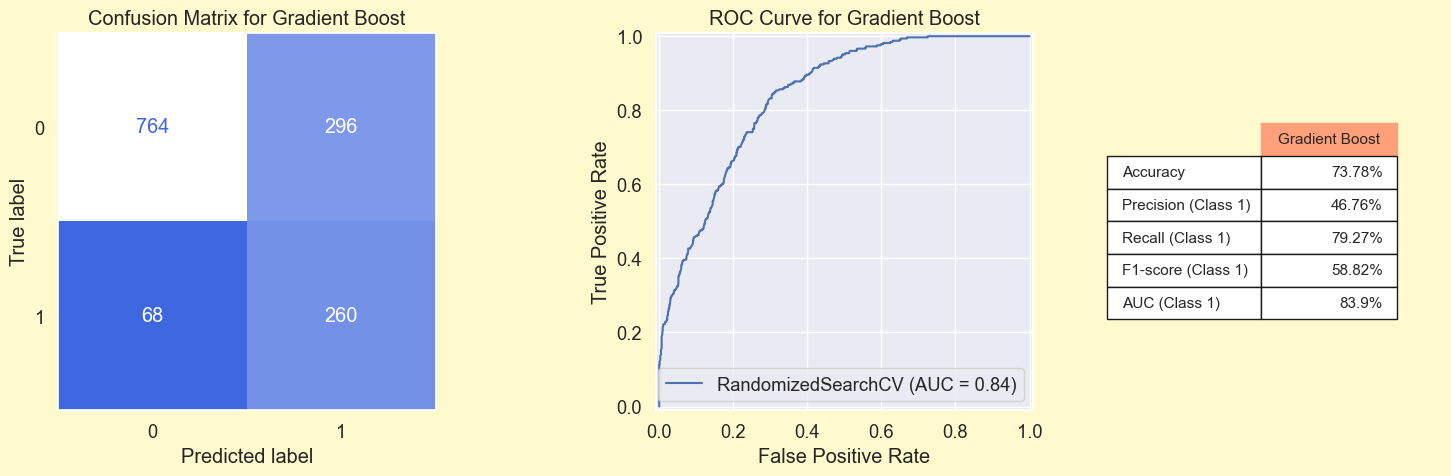

In [60]:
model_evaluation(random_search_gb, X_train, X_test, y_train, y_test, 'Gradient Boost')

**Insight :**

- Akurasi : 73,78% yang berarti Gradient Boost ini dengan benar memprediksi apakah sebuah booking akan dibatalkan atau tidak sebesar 74% dari seluruh total booking.
- Precision (Class 1) : 46,76%, yang menunjukan bahwa ±47% dari booking yang diprediksi akan dibatalkan memang benar-benar dibatalkan (True Positive).
- Recall (Class 1) : 79,27%, yang berarti model ini dapat mengidentifikasi sekitar 79% dari semua kasus pembatalan yang sebenarnya. 
- F1-score (Class 1) : 58,82%, merupakan rata-rata harmonic antara Precision dan Recall.
- AUC (Area Under the ROC Curve)(Class 1): 83.9%, menunjukan model dapat membedakan dengan cukup baik antara kelas positif dengan negatif, performa ini membuat model ini sedikit lebih baik dibandingkan Logistic Regression, dalam kasus ini membedakan antara orang yang tidak membatalkan pesanannya (Negatif) dengan orangan yang membatalkan pesanannya (Positif). 

Confusion matrix menunjukan bahwa masih terdapat 68 pesanan yang diprediksi tidak akan melakukan pembatalan tapi ternyata membtalkan pesanan (False Negatif), tapi disaat bersamaan berhasil memberikan hasil yang lebih baik pada True Positif dan True Negatif dibandingkan dengan Logistic Regression.

Ada peluang untuk menjadikan model ini menjadi model terbaik karena memiliki performa yang sedikit lebih baik dan seimbang pada semua aspek dibandingkan dengan Logistic Regression. Meskipun begitu kita akan coba bandingkan dengan AdaBoost yang akan kita evaluasi setelah ini. 

### Logistic Regression VS AdaBoost VS Gradient Boost

Secara umum, hasil pemodelan antara model Logistic Regression, Adaboost dan Gradient Boost dapat dilihat sebagai berikut :

In [61]:
# membuat tabulasi recall score
df_score = pd.DataFrame({
    'Logistic Regresion' : [score_recal_train[0], grid_search_logreg.best_score_,score_recal_test[0] , recall_tuned_test_logreg],
    'Gradient Boost' : [score_recal_train[5], random_search_gb.best_score_, score_recal_test[5], recall_tuned_test_gb],
    'AdaBoost' : [score_recal_train[4], grid_search_ada.best_score_, score_recal_test[4], recall_tuned_test_ada]
})

In [62]:
# untuk label index
outside = ['Train Set', 'Train Set', 'Test Set', 'Test Set']
inside = ['Benchmark Model', 'Tuning Model', 'Benchmark Model', 'Tuning Model']

hier_index = list(zip(outside, inside))

# membuat multiindex 
multi = pd.MultiIndex.from_tuples(hier_index)


In [63]:
# mengubah lavel index lama menjadi multi-index yang telah kita buat di atas
df_score.index = multi
df_score

Logistic Regresion  Gradient Boost  AdaBoost
Train Set Benchmark Model            0.751719        0.687548  0.653934
          Tuning Model               0.750215        0.786107  1.000000
Test Set  Benchmark Model            0.756098        0.679878  0.655488
          Tuning Model               0.783537        0.792683  1.000000

In [64]:
def evaluation_visualization(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    Fungsi ini bertujuan hanya untuk meanampilkan Confusiion Metrics dan AUC curve
    '''
    sns.set(font_scale=1.2)
    
    # Create figure and subplots 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]}, facecolor = 'lightsteelblue')
    
    # Define a colormap
    royalblue = LinearSegmentedColormap.from_list('crimson', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
    royalblue_r = royalblue.reversed()

    # Plot confusion matrix 
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=royalblue_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    
    # Plot AUC-ROC 
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')
    
    # Rekap hasil evaluasi
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('moccasin')

    # Add the title for the entire figure
    fig.suptitle(model_name, fontsize=16, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
    plt.show()

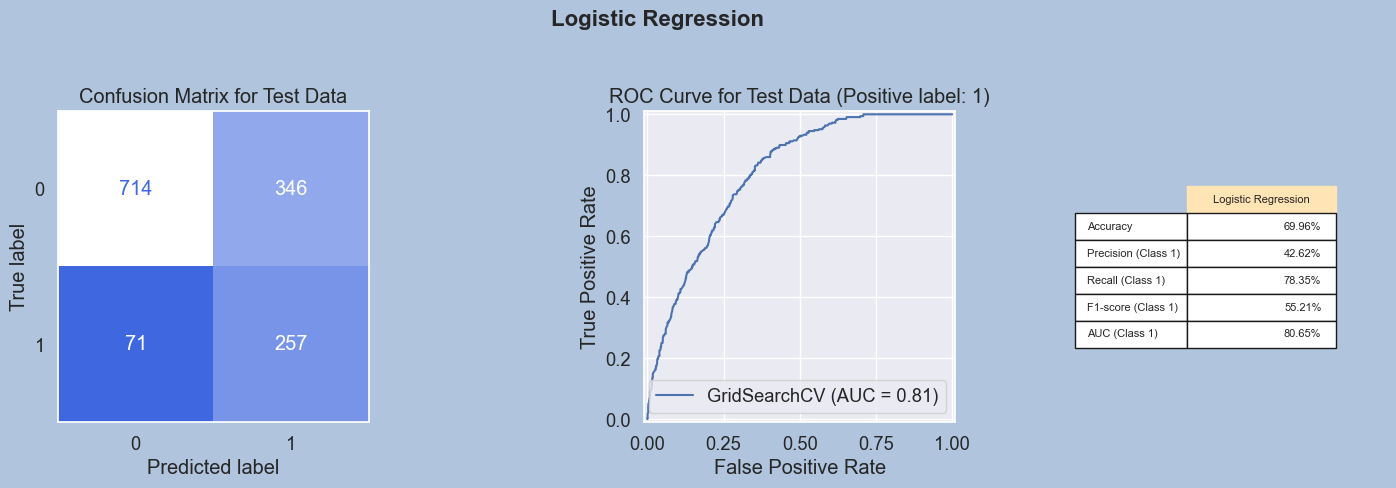

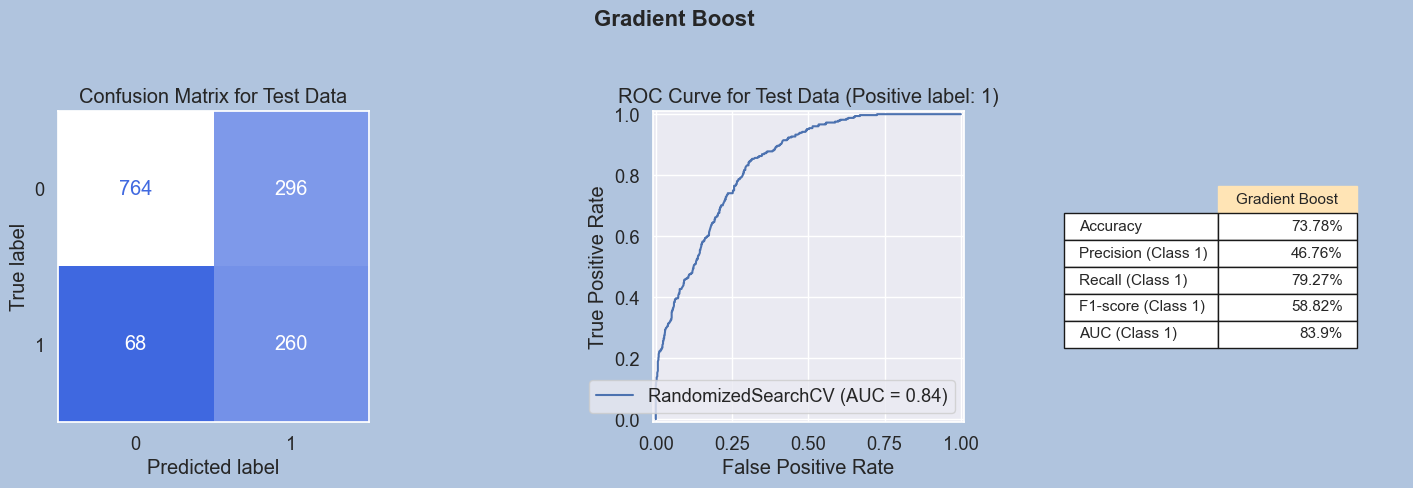

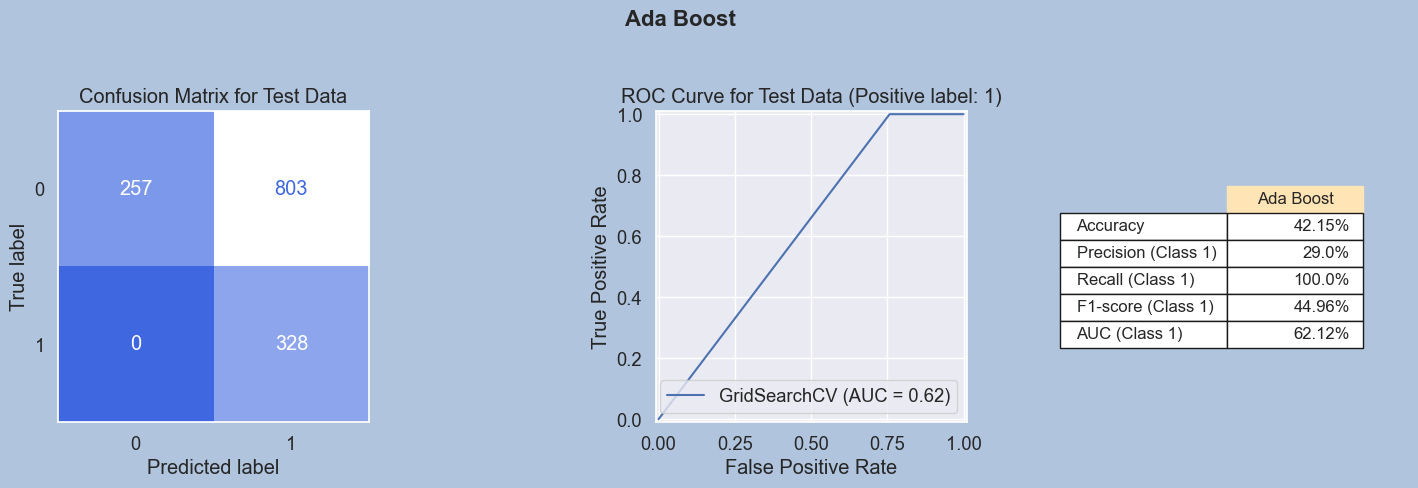

In [65]:
evaluation_visualization(grid_search_logreg, X_train, X_test, y_train, y_test, 'Logistic Regression')
evaluation_visualization(random_search_gb, X_train, X_test, y_train, y_test, 'Gradient Boost')
evaluation_visualization(grid_search_ada, X_train, X_test, y_train, y_test, 'Ada Boost')

Berdasarkan analisis ini:

- Gradient Boosting adalah model yang paling seimbang dan efektif dalam mendeteksi pembatalan dengan recall yang tinggi dan precision yang cukup baik. Ini membuatnya ideal untuk memprediksi pembatalan sambil meminimalkan false positives.
- Logistic Regression juga merupakan pilihan yang baik dengan recall yang tinggi, meskipun precision-nya sedikit lebih rendah dibandingkan Gradient Boosting.
- AdaBoost meskipun memiliki recall yang sempurna, tapi precision sangat rendah membuatnya kurang efisien untuk digunakan dalam skenario ini karena terlalu banyak false positives yang malah dapat menyebabkan terjadinya Overbooking.

Dengan mempertimbangkan tujuan awal untuk membantu hotel mengantisipasi dan mempertahankan tamu yang mungkin membatalkan, maka kita akan memilih Gradient Boost sebagai model yang akan digunakan karena menawarkan keseimbangan terbaik antara recall dan precision, dengan kemampuan diskriminasi yang sangat baik seperti yang ditunjukkan oleh AUC.

## *FINAL MODEL - Gradient Boost*

Model terbaik yang akan kita pakai adalah Gradient Boost yang telah dituning.

Gradient Boosting adalah teknik ensemble yang digunakan dalam machine learning untuk membangun model prediksi yang kuat dengan menggabungkan prediksi dari beberapa decision tree. Konsep dasar dari Gradient Boost adalah dengan membuat beberapa decision tree yang tidak dapat melakukan prediksi secara mandiri, dan kemudian digabungkan menggunakan teknik ensamble. Selama proses penggabungan akan ditemukan kesalahan yang kemudian model akan berusaha memperbaiki kesalahan dari model sebelumnya. Setiap model baru akan melakukan prediksi terhadap residu dari model sebelumnya.

<p align="center"><img src = https://www.researchgate.net/publication/351542039/figure/fig1/AS:11431281172877200@1688685833363/Flow-diagram-of-gradient-boosting-machine-learning-method-The-ensemble-classifiers.png>


In [66]:
# menyimpan algoritma model terbaik dari Gradient Boost sebagai best model
best_model = Pipeline([
    ('outlier', HandlingOutliers()),
    ('transformer', transformer),
    ('scaler', scaler),
    ('resampler',sekoteng),
    ('model', GradientBoostingClassifier(n_estimators=490,max_features=8,max_depth=2,learning_rate=0.01 , random_state=0))
])

best_model.fit(X_train, y_train)
y_pred_best_model = best_model.predict(X_test)
recall_score(y_test, y_pred_best_model) 

0.8048780487804879

Recall score 80% berarti bahwa model berhasil mengidentifikasi 80% dari semua contoh positif yang sebenarnya di dalam dataset uji, ini berarti model berhasil mendeteksi 80% dari semua reservasi yang sebenarnya dibatalkan

Recall dihitung dengan rumus:

$$ \text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}} $$

- **True Positives (TP):** Kasus di mana model memprediksi 'Cancel' dan sebenarnya itu adalah 'Cancel'.
- **False Negatives (FN):** Kasus di mana model memprediksi 'Not Cancel', tetapi sebenarnya itu adalah 'Cancel'.

Jadi, recall 80% menunjukkan bahwa dari semua reservasi yang benar-benar dibatalkan, 80% di antaranya berhasil diidentifikasi oleh model sebagai pembatalan. Namun, 20% sisanya tidak teridentifikasi (model menganggap mereka tidak dibatalkan).









### *`FEATURE IMPORTANCES`*

Mari sekarang kita lihat fitur/kolom apa saja yang paling penting untuk model Decision Tree kita

In [67]:

def get_feature_names(column_transformer):
    feature_names = []

    for name, transformer, columns in column_transformer.transformers_:
        if transformer == 'drop':
            continue
        elif transformer == 'passthrough':
            if isinstance(columns, slice):
                feature_names.extend(column_transformer._feature_names_in[columns])
            else:
                feature_names.extend(columns)
        elif hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out()
            feature_names.extend(names)
        elif hasattr(transformer, 'get_feature_names'):
            names = transformer.get_feature_names()
            feature_names.extend(names)
        else:
            if isinstance(columns, slice):
                feature_names.extend(column_transformer._feature_names_in[columns])
            else:
                feature_names.extend(columns)

    return feature_names

In [68]:
# mendapatkan nama fitur dari transformer
names = get_feature_names(transformer)
names

['market_segment_Complementary',
 'market_segment_Corporate',
 'market_segment_Direct',
 'market_segment_Groups',
 'market_segment_Offline TA/TO',
 'market_segment_Online TA',
 'deposit_type_Non Refund',
 'deposit_type_Refundable',
 'customer_type_Group',
 'customer_type_Transient',
 'customer_type_Transient-Party',
 'reserved_room_type_0',
 'reserved_room_type_1',
 'reserved_room_type_2',
 'reserved_room_type_3',
 'country_0',
 'country_1',
 'country_2',
 'country_3',
 'previous_cancellations',
 'booking_changes',
 'days_in_waiting_list',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [69]:
gb_model = best_model.named_steps['model']
gb_model

GradientBoostingClassifier(learning_rate=0.01, max_depth=2, max_features=8,
                           n_estimators=490, random_state=0)

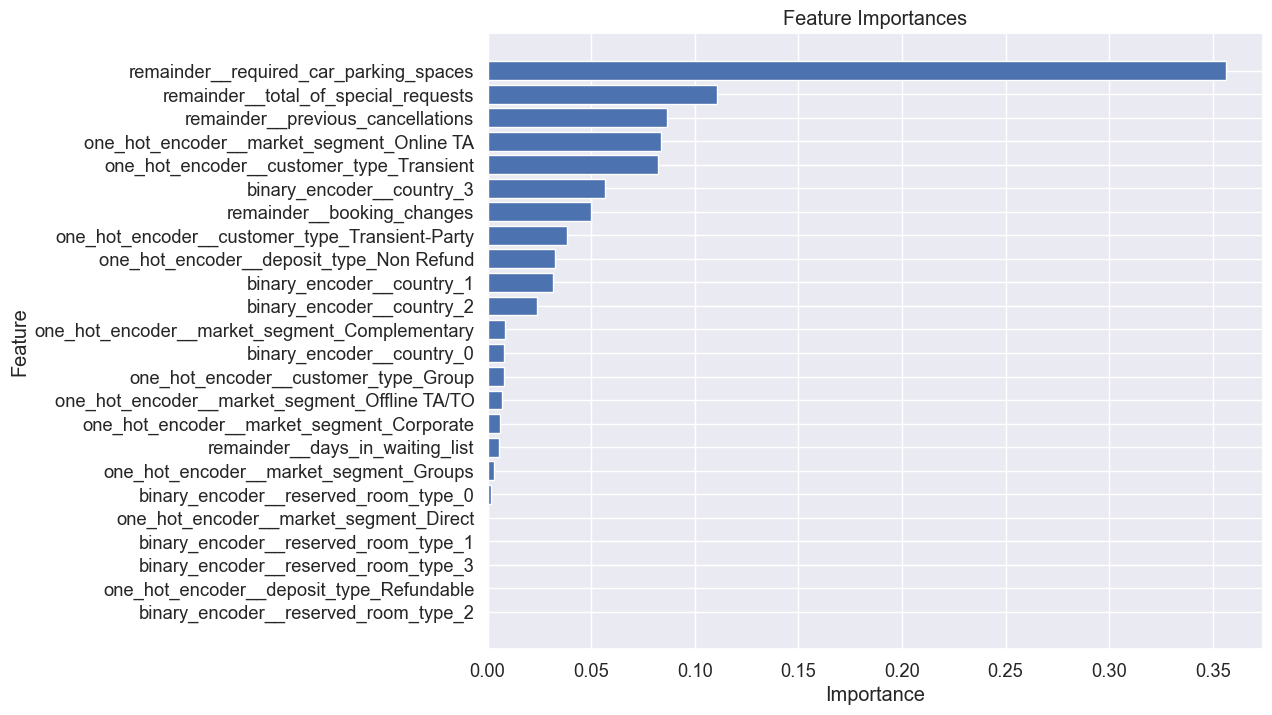

In [70]:
# Mengambil feature importances
feature_importances = gb_model.feature_importances_

# Mengambil nama-nama fitur setelah transformasi
if 'transformer' in best_model.named_steps:
    transformer = best_model.named_steps['transformer']
    try:
        feature_names = transformer.get_feature_names_out()
    except AttributeError:
        # Jika transformer tidak memiliki metode get_feature_names_out, gunakan alternatif
        if hasattr(transformer, 'transformers_'):
            feature_names = []
            for name, trans, columns in transformer.transformers_:
                if hasattr(trans, 'get_feature_names_out'):
                    feature_names.extend(trans.get_feature_names_out(columns))
                else:
                    feature_names.extend(columns)
        else:
            feature_names = X_train.columns
else:
    feature_names = X_train.columns

# Memastikan panjang feature_names sama dengan panjang feature_importances
if len(feature_names) != len(feature_importances):
    raise ValueError(f"Jumlah feature names ({len(feature_names)}) tidak sesuai dengan jumlah feature importances ({len(feature_importances)})")

# Mengurutkan fitur berdasarkan kepentingan
indices = np.argsort(feature_importances)[::-1]

# Menampilkan hasil feature importance
plt.figure(figsize=(10, 8))
plt.title("Feature Importances")
plt.barh(range(len(feature_importances)), feature_importances[indices], align="center")
plt.yticks(range(len(feature_importances)), np.array(feature_names)[indices])
plt.gca().invert_yaxis()  # Membalik sumbu y agar fitur terpenting berada di atas
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

1. Required Car Parking Spaces 

**Insight**: Ini adalah fitur yang paling penting. Jika pelanggan tidak membutuhkan ruang parkir, ini sangat mempengaruhi kemungkinan pembatalan.

**Actionable Steps**: Pertimbangkan untuk meningkatkan fasilitas parkir dan memberikan informasi yang jelas tentang jumlah parkir yang tersedia. Penawaran parkir gratis atau diskon untuk tamu yang melakukan pembayaran begitu melakukan pemesanan mungkin bisa mengurangi pembatalan.

2. total_of_special_requests 

**Insight:** Pelanggan dengan banyak permintaan khusus cenderung tidak membatalkan booking.

**Actionable Steps:** Memenuhi permintaan khusus pelanggan bisa meningkatkan kepuasan dan komitmen mereka untuk tidak membatalkan. Hotel bisa fokus pada personalisasi layanan untuk menurunkan tingkat pembatalan.

3. Previous Cancellations 

**Insight:** Riwayat pembatalan sebelumnya cukup berpengaruh. Pelanggan yang pernah membatalkan reservasi cenderung akan melakukan pembatalan lagi.

**Actionable Steps:** Buat kebijakan yang berbeda untuk tamu dengan riwayat pembatalan, seperti meminta deposit yang lebih tinggi dibanding tamu tanpa riwayat pembatalan.

4. Market Segment: Online TA

**Insight:** Segmentasi pasar dari Travel Agent online menunjukkan bahwa tamu yang memesan melalui cara ini lebih mungkin untuk membatalkan.

**Actionable Steps:** Kerjasama dengan agen perjalanan online untuk menawarkan kebijakan pembatalan yang lebih ketat atau memberikan insentif bagi tamu yang tidak membatalkan.

5. Customer Type: Transient 

**Insight:** Pelanggan tipe 'Transient' (pelanggan yang menginap hanya untuk satu malam atau periode singkat) juga berpengaruh terhadap pembatalan.

**Actionable Steps:** Fokus pada program loyalitas atau penawaran khusus untuk pelanggan transient untuk meningkatkan komitmen mereka terhadap reservasi.

6. Country 3 (0.059035)

**Insight:** Pelanggan dari negara tertentu (dalam hal ini negara yang diberi kode '3'/Portugal) memiliki kecenderungan lebih tinggi untuk membatalkan reservasi.

**Actionable Steps:** Lakukan analisis lebih lanjut untuk memahami mengapa tamu dari negara sendiri (Portugal) sering membatalkan dan sesuaikan strategi pemasaran atau komunikasi dengan mereka.

7. Booking Changes (0.042700)

**Insight:** Frekuensi perubahan reservasi juga berpengaruh. Semakin sering tamu mengubah reservasi, semakin besar kemungkinan mereka untuk membatalkan.

**Actionable Steps:** Buat proses perubahan reservasi yang lebih mudah dan jelas untuk mengurangi kebingungan dan ketidakpastian yang dapat menyebabkan pembatalan.

8. Customer Type: Transient-Party (0.043125)

**Insight:** Pelanggan tipe 'Transient-Party' juga memiliki dampak signifikan terhadap pembatalan.

**Actionable Steps:** Mungkin perlu memberikan penawaran atau diskon khusus untuk grup ini atau menawarkan fleksibilitas yang lebih tinggi dalam kebijakan reservasi mereka.


9. Other Market Segments and Features

**Insight:** Segmen pasar lain dan fitur-fitur seperti deposit type dan reserved room type juga memiliki pengaruh, meskipun lebih kecil.


##### *`LOCAL INTERPRETABLE MODEL-AGNOSTIC EXPLANATION (LIME)`*

In [71]:
trans_resample = Pipeline([
    ('outlier', HandlingOutliers()),
    ('transformer', transformer),
    ('scaler', scaler),
    ('resampler',sekoteng)
])

X_train_over, y_train_over = trans_resample.fit_resample(X_train, y_train)

In [72]:
import lime
from lime import lime_tabular

# Explainer based
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_over),
    feature_names=feature_names,
    class_names=['Not Cancel', 'Cancel'],
    mode='classification'
)

In [73]:
X_test_df = pd.DataFrame(best_model[1].transform(X_test), columns=feature_names)
X_test_df.iloc[[0,4]]

,one_hot_encoder__market_segment_Complementary,one_hot_encoder__market_segment_Corporate,one_hot_encoder__market_segment_Direct,one_hot_encoder__market_segment_Groups,one_hot_encoder__market_segment_Offline TA/TO,one_hot_encoder__market_segment_Online TA,one_hot_encoder__deposit_type_Non Refund,one_hot_encoder__deposit_type_Refundable,one_hot_encoder__customer_type_Group,one_hot_encoder__customer_type_Transient,...,binary_encoder__reserved_room_type_3,binary_encoder__country_0,binary_encoder__country_1,binary_encoder__country_2,binary_encoder__country_3,remainder__previous_cancellations,remainder__booking_changes,remainder__days_in_waiting_list,remainder__required_car_parking_spaces,remainder__total_of_special_requests
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,10.0,0.0,0.0,3.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0


**Explain Feature based on Pyplot**

The prediction must predict this Guest is: Not Cancel from y_test


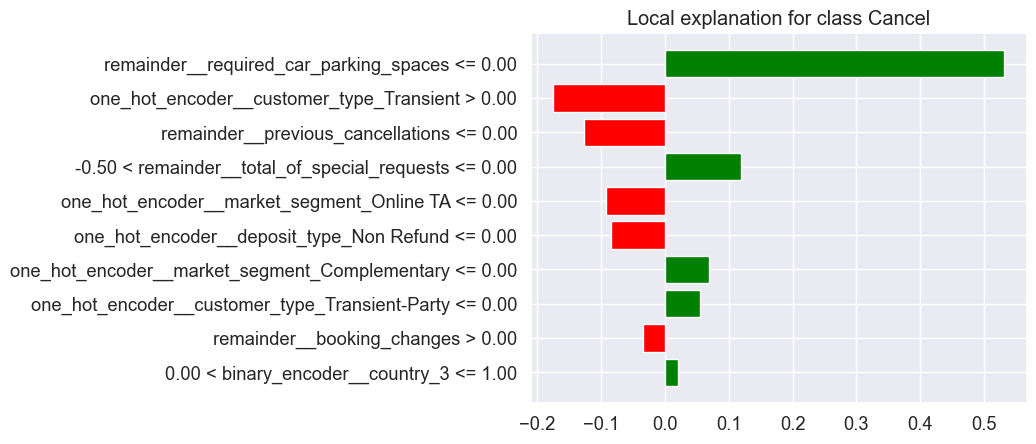

In [74]:

print(f"The prediction must predict this Guest is: {('Cancel' if y_test.iloc[8] == 1 else 'Not Cancel')} from y_test")

exp = explainer.explain_instance(X_test_df.iloc[8], 
                                 best_model['model'].predict_proba, 
                                 num_features=10)
exp.as_pyplot_figure();

1. required_car_parking_spaces <= 0.00 

**Interpretasi**: Tamu yang tidak memerlukan ruang parkir cenderung lebih 
mungkin membatalkan reservasi.

**Impact**: Sangat positif terhadap cancelation. Feature ini adalah feature dengan pengaruh terbesar pada prediksi model gradient boost

2. customer_type_Transient > 0.00 

**Interpretasi**: Tamu dengan tipe "Transient" (tamu individu yang menginap sementara) cenderung lebih kecil kemungkinannya untuk membatalkan reservasi.

**Impact**: Negatif terhadap cancelation, sehingga menunjukkan bahwa tamu dengan tipe transient cenderung lebih konsisten dalam mempertahankan reservasi mereka.

3. previous_cancellations <= 0.00 

**Interpretasi**: Tamu yang tidak memiliki riwayat pembatalan sebelumnya cenderung lebih mungkin membatalkan reservasi saat ini.

**Impact**: Negatif terhadap cancelation yang menunjukkan bahwa tamu baru yang belum pernah membatalkan sebelumnya lebih cenderung tidak pasti dengan reservasi mereka.

4. -0.50 < total_of_special_requests <= 0.00 

**Interpretasi**: Tamu dengan jumlah permintaan khusus yang rendah cenderung lebih mungkin membatalkan reservasi.

**Impact**: Positif terhadap cancelation yang menunjukkan bahwa tamu yang lebih banyak permintaan khusus mungkin lebih berkomitmen pada reservasi mereka.

5. market_segment_Online TA <= 0.00 

**Interpretasi**: Tamu yang tidak berasal dari segmen pasar "Online Travel Agency" cenderung lebih kecil kemungkinannya untuk membatalkan.

**Impoact**: Negatif terhadap cancelation. Ini menunjukkan bahwa tamu dari segmen "Online TA" memiliki tingkat pembatalan yang lebih tinggi.



##### *`CONFUSION MATRIX`*

<Axes: >

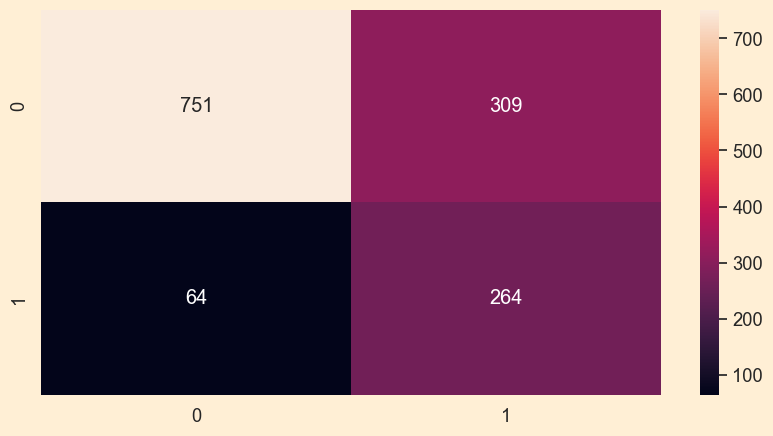

In [75]:
plt.figure(figsize=(10,5), facecolor='papayawhip')
sns.heatmap(confusion_matrix(y_test, y_pred_best_model), annot=True, fmt=".0f")

Berdasarkan confusion matrix pada test set di atas terlihat bahwa dengan model Gradient Boost yang telah kita buat, dapat dilihat bahwa:
- Jumlah pelanggan yang aktualnya cancel dan diprediksi akan membatalkan pesanan (True Positive) : 254 orang
- Jumlah pelanggan yang aktualnya cancel tetapi diprediksi tidak membatalkan pesanan (False Negative) : 64 orang
- Jumlah pelanggan yang aktualnya tidak membatalkan pesanan dan diprediksi tidak membatalkan pesanan (True Negative) : 751 orang
- Jumlah pelanggan yang aktualnya tidak membatalkan pesanan tetapi diprediksi akan cancel (False Positive) : 309 orang
- Jumlah pelanggan yang diprediksi akan cancel sebanyak 265 + 309 = 532 orang
- Jumlah pelanggan yang diprediksi tidak akan cancel sebanyak 751 + 64 = 815 orang

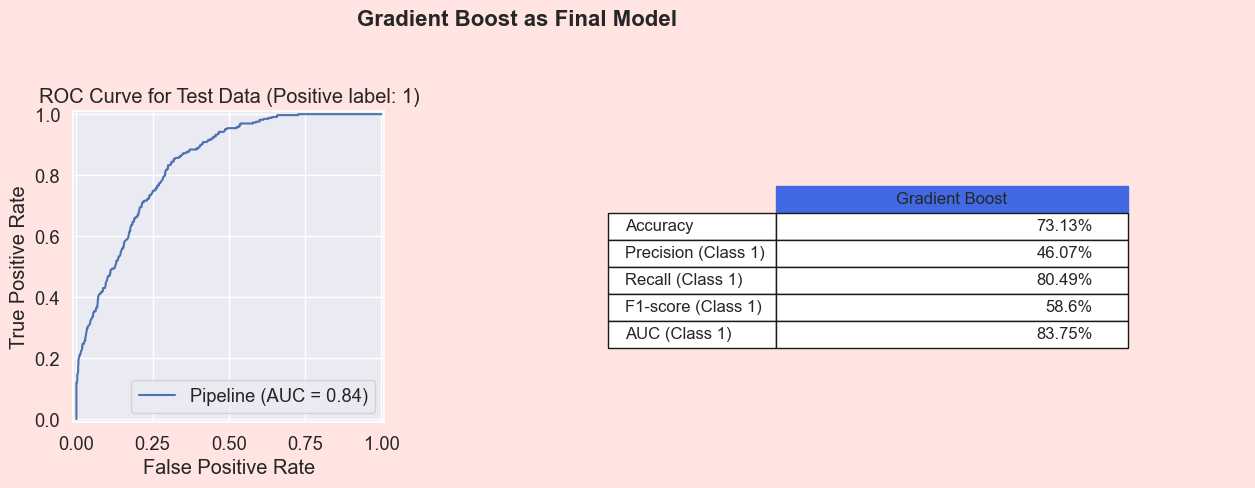

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [3, 2]},facecolor='mistyrose')
    
# Plot ROC curve for test data and display AUC score 
RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax1)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve for Test Data (Positive label: 1)')

# Report results for the class specified by positive label
result = metrics_calculator(best_model, X_test, y_test, 'Gradient Boost')
table = ax2.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
table.scale(0.6, 2)
table.set_fontsize(12)
ax2.axis('tight')
ax2.axis('off')
# Modify color 
for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_color('royalblue')

# Add the title for the entire figure
fig.suptitle('Gradient Boost as Final Model', fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
plt.show()

- **Accuracy** = 73.13% artinya, dari keseluruhan tamu yang dites (1,388 orang), 73.13%-nya berhasil berhasil diprediksi dengan benar (1015 orang)

- **Precision** = Nilai precision 46.07% artinya, dari total pelanggan yang diklasifikasikan akan cancel (532 orang), hanya 46.07%-nya yang berhasil terprediksi dengan benar (245 orang).

- **Recall** = Nilai recall 80.49% artinya, dari total pelanggan yang aslinya cancel (328 orang), 80.49%-nya berhasil diprediksi dengan benar (264 orang)

- **F1-score** = 58,6%

$$F1 = 2 \times\frac{ Precision \times Recall}{Precision + Recall}$$

- **AUC Score** = 83,75%, ini menunjukan bahwa model dapat mengidentifikasi dengan baik antara kelas positif dan negatif.



## *IMPACT OF MACHINE LEARNING*

Berdasarkan perhitungan yang telah kita hitung diawal pada bagian Business Understanding, kita asumsikan dampak biayanya sebagai berikut :
- Kerugian hotel per cancel = 1,15x dari harga kamar per malam
- Pelanggan yang melakukan cancel sebelum diterapklan machine learning = FN+TP = 328 orang
- Total kerugian hotel sebelum machine learning = 328 orang x 1.15kali harga kamar = **377.2 kali harga kamar**
- dalam USD = 377.2 x $99 = $37,342.8

- Pelanggan yang gagal diprediksi cancel = 64 orang
- Total kerugian yang gagal diantisipasi hotel = 64 orang x 1.15kali harga kamar = **73.6 kali harga kamar** 
- dalam USD = 73.6 x $99 = $7,286.4

Dengan menggunakan machine learning hotel tersebut dapat meminimalkan kerugian hingga **80,49%** atau sebesar **$30,056.4** 

## **CONCLUSION & RECOMMENDATION**

#### *CONCLUSION*

- Metric yang kita gunakan adalah **recall score**, karena kita ingin agar model dapat mengurangi jumlah False Negative (pelanggan yang aktualnya cancel tetapi diprediksi No Cancel).
    <br>
    <br>
- Berdasarkan hyperparameter tuning, parameter terbaik yang dapat digunakan untuk benchmark model Decision Tree adalah :
    - n_estimators = 88 
    - max_features = 3
    - max_depth = 3
    - learning_rate = 0.08
    <br>
    <br>
- Berdasarkan permodelan Gradient Boost, feature `required_car_parking_space` adalah yang paling berpengaruh bagi tamu untk melakukan cancel atau tidak yang kemudian diikuti dengan `previous_cancellation` dan `customer_type`.
    <br>
    <br>
- Berdasarka hasil interpretasi pada Gradient Boost maka kita dapat simpulkan hal-hal sebagai berikut :
    - `required_car_parking_space` dan `previous_cancelation` sangat berpengaruh terhadap keputusan seorang tamu untuk melakukan cancel atau tidak
    - Tamu yang sebelumnya telah melakukan pembatalan pesanan lebih dari 10 kali maka memiliki kecenderungan besar untuk membatalkan pesanan
    - Pelanggan dengan tipe Transient (pelanggan yang hanya menginap selama satu malam/periode singkat) memiliki kecenderungan besar untuk membatalkan pesanan
    - Tamu yang berasal dari Portugal adalah tamu yang paling banyak membatalkan pesanan
    
    <br>
    <br>
- Berdasarkan contoh perhitungan biaya :
    - Kerugian hotel per cancel = 1,15x dari harga kamar per malam
    - Pelanggan yang melakukan cancel sebelum diterapklan machine learning = FN+TP = 328 orang
    - Total kerugian hotel sebelum machine learning = 856 orang x 1,15kali harga kamar = **377,2 kali harga kamar**
    - dalam USD = 377.2 x $99 = $37,342.8

    - Pelanggan yang gagal diprediksi cancel = 64 orang
    - Total kerugian yang gagal diantisipasi hotel = 64 orang x 1,15kali harga kamar = **73,6 kali harga kamar**
    - dalam USD = 73.6 x $99 = $7,286.4

    Dengan menggunakan machine learning hotel tersebut dapat meminimalkan kerugian hingga **80,49%** atau sebesar **$30,056.4**
    <br>
    <br>

In [77]:
outlier_handle = HandlingOutliers()
df_transform = outlier_handle.fit_transform(hotel_data)

# Hitung statistik deskriptif untuk kolom yang di-winsorize
cols_to_winsorize = ['previous_cancellations', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces']
descriptive_stats = df_transform[cols_to_winsorize].describe()
descriptive_stats

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces
count,6937.000000,6937.000000,6937.000000,6937.000000
mean,0.073086,0.946807,4.400750,0.192302
std,0.320382,1.263986,20.494788,0.394138
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000
max,2.000000,6.000000,147.000000,1.000000


**Model Limitation**

Kita harus berhati-hati ketika melakukan interpretasi di luar interval amatan independen variabel.

Model ini hanya berlaku pada rentang data yang digunakan pada pemodelan ini yaitu :

* `country` hanya menampilkan 10 negara dengan jumlah tamu terbanyak, sedangkan negara diluar itu dikategorikan sebagai *others* 
* `market_segemet` hanya terdapat 7 market segment yang dapat diolah pada model ini (Aviation, Complementary, Corporate, Direct, Groups, Offline TA/TO, Online TA)
* `previous_cancellation` pada rentang 0 - 2 kali pembatalan
* `booking_changes` hanya dapat menangani 0-6 kali pergantian booking
* `days_in_waiting_list` pada rentang 0-147 hari
* `deposit_type` berupa 'No Deposit', 'Non Refund' dan 'Refundable'
* `customer_type` hanya terdapat 4 kategori yaitu Contract, Group, Transient, Transient-Party
* `required_car_parking_spaces` hanya terdapat 2 kategori yaitu 0 atau 1

#### *RECOMMENDATION*

Strategi Bisnis yang Dapat Diterapkan
1. Tingkatkan Fasilitas Parkir: Mengingat ketersediaan parkir sangat berpengaruh, investasi dalam fasilitas parkir atau memberikan informasi yang jelas tentang parkir bisa mengurangi pembatalan.

2. Kebijakan untuk Riwayat Pembatalan: Terapkan kebijakan khusus bagi tamu dengan riwayat pembatalan, seperti deposit lebih tinggi atau pengingat reservasi tambahan.

3. Program Loyalitas untuk Pelanggan Transient: Buat program loyalitas atau penawaran khusus untuk meningkatkan komitmen tamu transient.

4. Optimalkan Manajemen Permintaan Khusus: Pastikan permintaan khusus tamu dapat dipenuhi atau komunikasikan batasan dengan jelas.

5. Kerjasama dengan Agen Perjalanan Online: Tinjau kebijakan pembatalan dan insentif bagi tamu yang memesan melalui agen perjalanan online untuk mengurangi pembatalan.

6. Analisis Negara Asal Tamu: Lakukan analisis lebih mendalam tentang mengapa tamu dari negara sendiri (Portugal) lebih sering membatalkan dan sesuaikan strategi pemasaran dan komunikasi.

Beberapa penambahan dan peningkatan yang disarankan untuk dilakukan agar dap meningkatkan performa model dan pengenmbangan bisnis :

- Menambahkan fitur yang dapat diisi oleh tamu terkait tingkat kepuasan dan pengalaman menginap agar dapat diketahui apakah tamu yang cancel disebabkan oleh kualitas layanan yang buruk atau tidak.
- Melakukan anonimasi nama tamu yang menginap sehingga tiap data menjadi unik serta tidak menimbulkan banyak nilai duplikat dan jumlah data yang dipelajari oleh model bisa jadi lebih banyak.
- Menambahkan fitur yang berisi sudah berapa kali tamu menginap di hotel tersebut, sehingga kita dapat melakukan pemetaan untuk menjaga loyalitas tamu dan mengetahui bagian apa dari hotel yang bisa menjadi daya tarik bagi tamu untuk datang kembali. 
- Mencoba metode handling outlier yang berbeda seperti Transform Method (Log Transformation, Square Root Transformation) atau dengan metode clustering seperti (DBSCAN)
- Menambahkan fitur-fitur atau kolom baru yang berisi durasi atau biaya penggunaan produk-produk yang ada seperti panggilan suara, SMS, dan internet. Sehingga perusahaan dapat melakukan segmentasi pelanggan untuk menentukan jenis produk yang paling sesuai untuk ditawarkan.
- Menganalisa data-data yang model yang masih salah prediksi (False Negative dan False Positive) untuk mengetahui alasan dan karakteristiknya.

## *SAVE FINAL MODEL*

In [78]:
import pickle

In [79]:
# fit
best_model.fit(X, y)

# save with pickle
pickle.dump(best_model, open('best_model_gradboost.sav', 'wb'))